## 1. Import Librerie

## 1. Import Librerie

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Configurazione per grafici più grandi e leggibili
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dati

In [ ]:
# Carica il file CSV
#filename = 'accel_data_20251120_152715.csv'
filename = 'accel_data_20251120_152940.csv'

df = pd.read_csv(filename)

# Mostra le prime righe
print(f"📊 Dataset caricato: {len(df)} campioni")
print(f"⏱️  Durata: {df['Timestamp'].max() - df['Timestamp'].min():.2f} secondi")
print(f"📈 Frequenza di campionamento: ~{len(df)/(df['Timestamp'].max() - df['Timestamp'].min()):.1f} Hz\n")

df.head(10)

📊 Dataset caricato: 1008 campioni
⏱️  Durata: 20.00 secondi
📈 Frequenza di campionamento: ~50.4 Hz



,Timestamp,X (g),Y (g),Z (g),Magnitude (g)
0,17.133,0.156250,-0.953125,-0.093750,0.970387
1,17.133,0.156250,-0.953125,-0.093750,0.970387
2,17.133,0.171875,-0.937500,-0.093750,0.957725
3,17.133,0.156250,-0.921875,-0.109375,0.941398
4,17.172,0.171875,-0.921875,-0.125000,0.946055
5,17.204,0.171875,-0.937500,-0.093750,0.957725
6,17.204,0.171875,-0.968750,-0.109375,0.989940
7,17.206,0.171875,-0.953125,-0.093750,0.973025
8,17.243,0.171875,-0.968750,-0.078125,0.986976
9,17.244,0.140625,-0.968750,-0.078125,0.982016


## 3. Visualizzazione Dati Grezzi

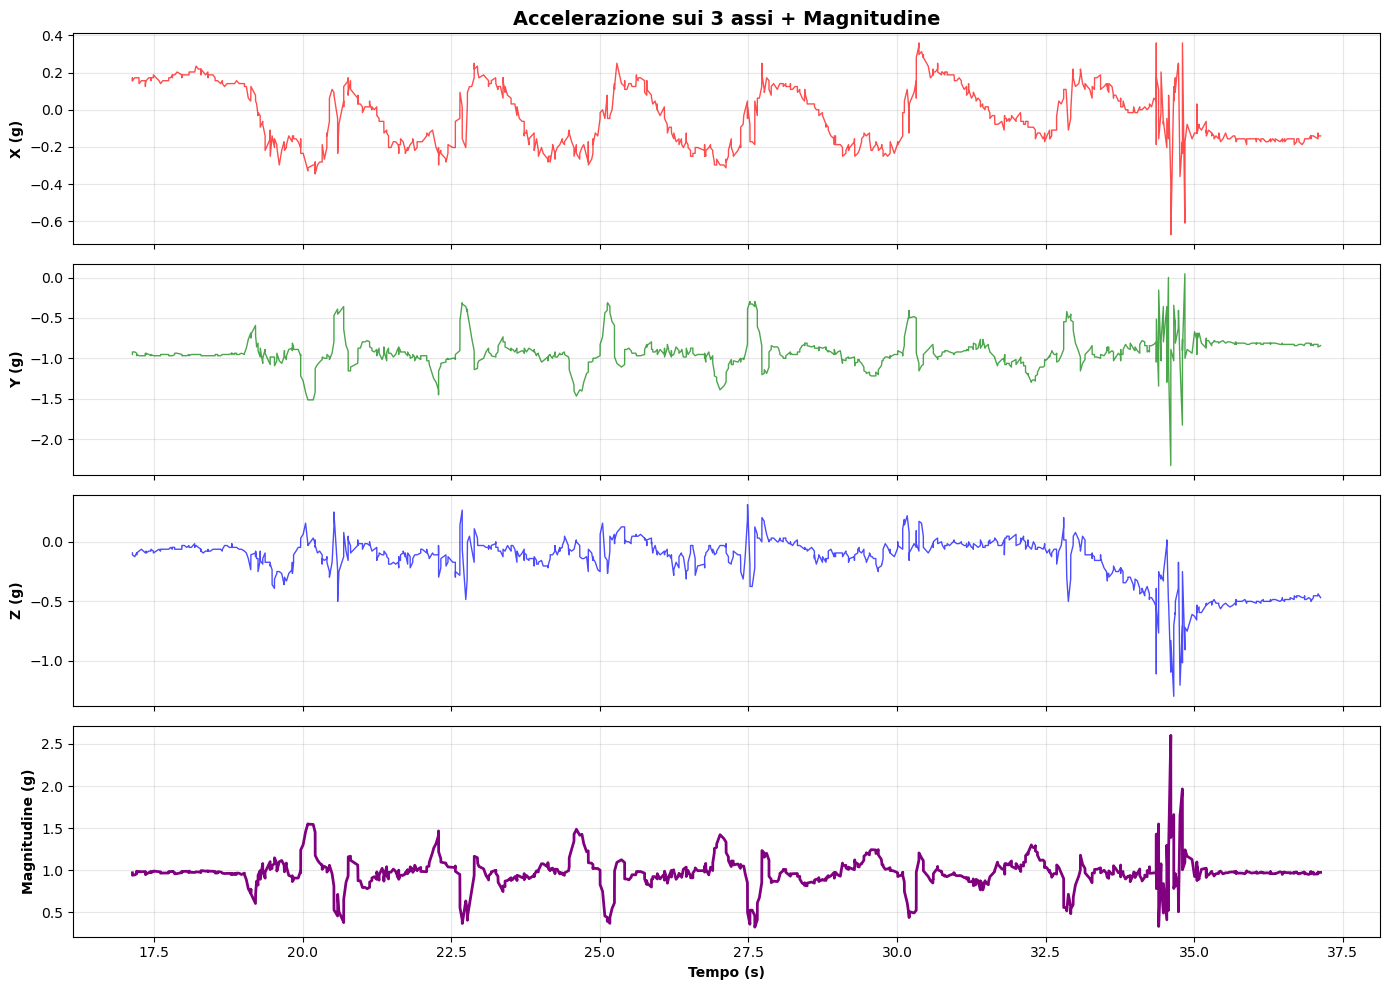

In [ ]:
# Plot dei dati grezzi
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['Timestamp'], df['X (g)'], 'r-', alpha=0.7, linewidth=1)
axes[0].set_ylabel('X (g)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Accelerazione sui 3 assi + Magnitudine', fontsize=14, fontweight='bold')

axes[1].plot(df['Timestamp'], df['Y (g)'], 'g-', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Y (g)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Timestamp'], df['Z (g)'], 'b-', alpha=0.7, linewidth=1)
axes[2].set_ylabel('Z (g)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['Timestamp'], df['Magnitude (g)'], 'purple', linewidth=2)
axes[3].set_ylabel('Magnitudine (g)', fontweight='bold')
axes[3].set_xlabel('Tempo (s)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Smoothing e Preprocessing

In [ ]:
# Applica smoothing gaussiano per ridurre il rumore
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sigma = 2  # Parametro di smoothing

df['X_smooth'] = gaussian_filter1d(df['X (g)'], sigma=sigma)
df['Y_smooth'] = gaussian_filter1d(df['Y (g)'], sigma=sigma)
df['Z_smooth'] = gaussian_filter1d(df['Z (g)'], sigma=sigma)
df['Mag_smooth'] = gaussian_filter1d(df['Magnitude (g)'], sigma=sigma)

# Calcola la derivata (velocità) della magnitudine per identificare cambiamenti
df['Mag_velocity'] = np.gradient(df['Mag_smooth'], df['Timestamp'])
df['Mag_velocity_smooth'] = gaussian_filter1d(df['Mag_velocity'], sigma=sigma)

print("✅ Smoothing applicato")

✅ Smoothing applicato


## 5. Analisi Baseline e Soglie

Per la bench press, la baseline rappresenta la **barra in lockout** (posizione di partenza/riposo in alto).
Il movimento è **identico allo squat**: si parte dalla posizione alta e si scende a caricare.

**Pattern del movimento:**
1. **Baseline/Lockout** - Posizione di partenza in alto, stabile (~0.97g)
2. **Fase eccentrica** - Discesa controllata verso il petto, magnitudine scende (può arrivare a ~0.74g)
3. **Chest touch/Bottom** - Tocco al petto, punto più basso

4. **Fase concentrica** - Spinta esplosiva verso l'alto, accelerazione positiva, magnitudine sale sopra 1.0g⚠️ **Nota sul rebound**: Dopo il picco concentrico si può vedere un secondo minimo sul grafico - questo è il **rebound dell'accelerometro**, non un movimento reale della barra!

5. **Ritorno lockout** - Ritorno alla posizione di partenza in alto

In [ ]:
# Analisi Magnitude con Soglie per Bench Press

mag = df['Mag_smooth'].values
timestamps = df['Timestamp'].values

print("🔍 ANALISI MAGNITUDE - BENCH PRESS")
print("=" * 80)

# Per bench press, baseline è la posizione di lockout (primi campioni stabili in alto)
baseline_samples = int(len(mag) * 0.2)
baseline_value = np.median(mag[:baseline_samples])

# Soglie per bench press (movimento IDENTICO allo squat: parte da alto e scende)
threshold_percent = 0.05  # 5% della baseline
upper_threshold = baseline_value + (baseline_value * threshold_percent)
lower_threshold = baseline_value - (baseline_value * threshold_percent)

print(f"📊 Baseline (barra in lockout/alto): {baseline_value:.3f}g")
print(f"📊 Soglia superiore (+5%): {upper_threshold:.3f}g")
print(f"📊 Soglia inferiore (-5%): {lower_threshold:.3f}g")

# Trova quando le soglie vengono rotte
upper_breaks = np.where(mag > upper_threshold)[0]
lower_breaks = np.where(mag < lower_threshold)[0]

print(f"\n🔴 Soglia superiore rotta in {len(upper_breaks)} punti (fase concentrica - spinta)")
if len(upper_breaks) > 0:
    print(f"   Primo break: t={timestamps[upper_breaks[0]]:.2f}s (Mag={mag[upper_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[upper_breaks[-1]]:.2f}s (Mag={mag[upper_breaks[-1]]:.3f}g)")

print(f"\n🟢 Soglia inferiore rotta in {len(lower_breaks)} punti (discesa eccentrica)")
if len(lower_breaks) > 0:
    print(f"   Primo break: t={timestamps[lower_breaks[0]]:.2f}s (Mag={mag[lower_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[lower_breaks[-1]]:.2f}s (Mag={mag[lower_breaks[-1]]:.3f}g)")

print("=" * 80)

🔍 ANALISI MAGNITUDE - BENCH PRESS
📊 Baseline (barra in lockout/alto): 0.978g
📊 Soglia superiore (+5%): 1.027g
📊 Soglia inferiore (-5%): 0.929g

🔴 Soglia superiore rotta in 240 punti (fase concentrica - spinta)
   Primo break: t=19.45s (Mag=1.029g)
   Ultimo break: t=35.01s (Mag=1.053g)

🟢 Soglia inferiore rotta in 249 punti (discesa eccentrica)
   Primo break: t=19.02s (Mag=0.901g)
   Ultimo break: t=34.69s (Mag=0.925g)


## 6. Visualizzazione con Marker delle Soglie

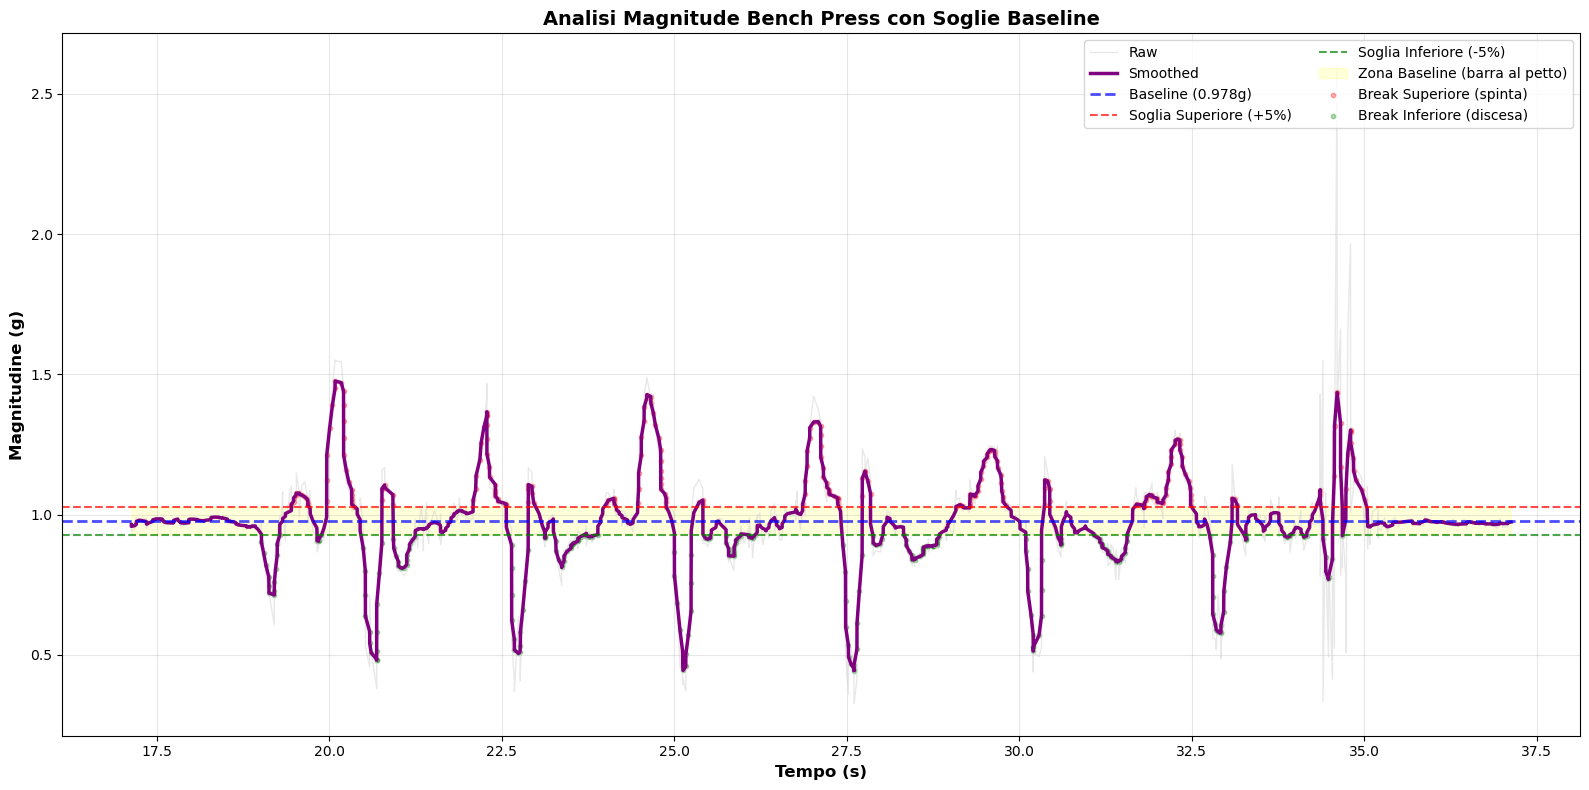

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot magnitudine
ax.plot(df['Timestamp'], df['Magnitude (g)'], 'lightgray', alpha=0.5, linewidth=1, label='Raw')
ax.plot(df['Timestamp'], df['Mag_smooth'], 'purple', linewidth=2.5, label='Smoothed')

# Linee delle soglie
ax.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline ({baseline_value:.3f}g)', alpha=0.7)
ax.axhline(y=upper_threshold, color='red', linestyle='--', linewidth=1.5, label=f'Soglia Superiore (+5%)', alpha=0.7)
ax.axhline(y=lower_threshold, color='green', linestyle='--', linewidth=1.5, label=f'Soglia Inferiore (-5%)', alpha=0.7)

# Zona baseline (fill between)
ax.fill_between(df['Timestamp'], lower_threshold, upper_threshold, color='yellow', alpha=0.15, label='Zona Baseline (barra al petto)')

# Evidenzia i punti dove le soglie vengono rotte
if len(upper_breaks) > 0:
    ax.scatter(timestamps[upper_breaks], mag[upper_breaks], color='red', s=10, alpha=0.3, label='Break Superiore (spinta)')

if len(lower_breaks) > 0:
    ax.scatter(timestamps[lower_breaks], mag[lower_breaks], color='green', s=10, alpha=0.3, label='Break Inferiore (discesa)')

ax.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
ax.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
ax.set_title('Analisi Magnitude Bench Press con Soglie Baseline', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

## 7. Rilevamento Ripetizioni con Pattern Matching

Algoritmo basato su **sequenze di accelerazione** - pattern identico allo squat:

**Sequenza completa di una ripetizione:**
1. **LOCKOUT (baseline)** - Partenza in alto, stabile
2. **FASE ECCENTRICA** - Discesa controllata verso il petto (mag scende sotto baseline)
3. **CHEST TOUCH (bottom)** - Tocco al petto, punto più basso
4. **FASE CONCENTRICA (spinta)** ← qui calcoliamo VBT - Spinta esplosiva (mag sale sopra 1.0g)
5. **PICCO CONCENTRICO** - Massima accelerazione durante la spinta
6. **REBOUND** - ⚠️ Oscillazione accelerometro (NON movimento reale!)

7. **RITORNO LOCKOUT** - Ritorno alla posizione alta di partenzaL'algoritmo cerca la sequenza: LOCKOUT → DISCESA → CHEST TOUCH → SPINTA → LOCKOUT


In [ ]:
"""
PATTERN MATCHING con VBT (Velocity Based Training) per BENCH PRESS
Rilevamento ripetizioni tramite transizioni di stato + calcolo metriche VBT avanzate
"""

# Configura parametri per bench press
BASELINE_ZONE = 0.08  # ±8% variazione = stato BASE
MIN_REP_DURATION = 0.5  # secondi
MAX_REP_DURATION = 4.0  # secondi
REFRACTORY_PERIOD = 0.8  # secondi tra ripetizioni
PEAK_PROMINENCE = 0.15  # Prominenza minima dei picchi

# Calcola baseline (barra in lockout - posizione alta di partenza)
baseline_samples = 30
baseline_value = np.median(mag[:baseline_samples])
baseline_upper = baseline_value * (1 + BASELINE_ZONE)
baseline_lower = baseline_value * (1 - BASELINE_ZONE)

print(f"📊 BASELINE ANALYSIS - BENCH PRESS")
print(f"   Baseline (barra in lockout/alto): {baseline_value:.3f}g")
print(f"   Upper threshold (+{BASELINE_ZONE*100:.0f}%): {baseline_upper:.3f}g")
print(f"   Lower threshold (-{BASELINE_ZONE*100:.0f}%): {baseline_lower:.3f}g")
print("=" * 90)

# Classifica samples in stati
# ABOVE = picco durante spinta, BASE = lockout, BELOW = discesa eccentrica/chest touch
signal_state = np.where(mag > baseline_upper, 1,  # ABOVE
                        np.where(mag < baseline_lower, -1,  # BELOW
                                 0))  # BASE

# Trova transizioni di stato
state_changes = []
for i in range(1, len(signal_state)):
    if signal_state[i] != signal_state[i-1]:
        state_changes.append({
            'idx': i,
            'time': timestamps[i],
            'from_state': signal_state[i-1],
            'to_state': signal_state[i],
            'mag': mag[i]
        })

print(f"🔄 State transitions detected: {len(state_changes)}")

# Pattern Matching per BENCH PRESS: cerca BASE → SPINTA (ABOVE) → BASE
valid_reps = []
last_rep_end_time = -REFRACTORY_PERIOD

for i in range(len(state_changes) - 1):
    # Cerca inizio spinta: esce da BASE verso ABOVE
    if state_changes[i]['from_state'] == 0 and state_changes[i]['to_state'] == 1:
        rep_start_idx = state_changes[i]['idx']
        rep_start_time = state_changes[i]['time']
        
        # Applica refractory period
        if rep_start_time - last_rep_end_time < REFRACTORY_PERIOD:
            continue
        
        # Cerca ritorno a BASE dopo la spinta
        for j in range(i + 1, len(state_changes)):
            if state_changes[j]['to_state'] == 0:  # Ritorna a BASE
                rep_end_idx = state_changes[j]['idx']
                rep_end_time = state_changes[j]['time']
                rep_duration = rep_end_time - rep_start_time
                
                # Valida durata
                if MIN_REP_DURATION <= rep_duration <= MAX_REP_DURATION:
                    # Trova picco concentrico (massimo nella fase di spinta)
                    mag_segment = mag[rep_start_idx:rep_end_idx+1]
                    
                    if len(mag_segment) < 20:  # Minimo 20 samples
                        continue
                    
                    # Per bench press: il picco è nella fase concentrica (massimo)
                    concentric_peak_relative = np.argmax(mag_segment)
                    concentric_peak_idx = rep_start_idx + concentric_peak_relative
                    
                    # Verifica che ci sia stata effettiva accelerazione (picco > 1.0g)
                    if mag[concentric_peak_idx] <= 1.0:
                        continue
                    
                    # Cerca il punto più basso nella fase eccentrica (dopo il picco)
                    if concentric_peak_relative < len(mag_segment) - 1:
                        eccentric_segment = mag_segment[concentric_peak_relative:]
                        eccentric_bottom_relative = np.argmin(eccentric_segment)
                        eccentric_bottom_idx = concentric_peak_idx + eccentric_bottom_relative
                    else:
                        eccentric_bottom_idx = rep_end_idx
                    
                    # Salva ripetizione valida
                    rep = {
                        'rep_num': len(valid_reps) + 1,
                        'start_idx': rep_start_idx,
                        'end_idx': rep_end_idx,
                        'concentric_peak_idx': concentric_peak_idx,
                        'eccentric_bottom_idx': eccentric_bottom_idx,
                        'start_time': rep_start_time,
                        'end_time': rep_end_time,
                        'concentric_peak_time': timestamps[concentric_peak_idx],
                        'eccentric_bottom_time': timestamps[eccentric_bottom_idx],
                        'duration': rep_duration,
                        'mag_start': mag[rep_start_idx],
                        'mag_peak': mag[concentric_peak_idx],
                        'mag_bottom': mag[eccentric_bottom_idx],
                        'mag_end': mag[rep_end_idx]
                    }
                    valid_reps.append(rep)
                    last_rep_end_time = rep_end_time
                    break

print(f"\n✅ Valid repetitions detected: {len(valid_reps)}")
print("=" * 90)

# CALCOLO METRICHE VBT per ogni ripetizione
reps_with_metrics = []  # Solo le reps con metriche VBT valide

if len(valid_reps) > 0:
    for rep in valid_reps:
        # Estrai fase concentrica (start → peak)
        start_idx = rep['start_idx']
        concentric_peak_idx = rep['concentric_peak_idx']
        
        if concentric_peak_idx <= start_idx:
            print(f"⚠️  Rep {rep['rep_num']}: Invalid concentric phase (peak before start)")
            continue
        
        mag_concentric = mag[start_idx:concentric_peak_idx+1]
        time_concentric = timestamps[start_idx:concentric_peak_idx+1]
        
        if len(mag_concentric) < 2:
            print(f"⚠️  Rep {rep['rep_num']}: Too few samples in concentric phase")
            continue
        
        # GRAVITY COMPENSATION - sottrai 1.0g per accelerazione netta
        mag_accel_net = (mag_concentric - 1.0) * 9.81  # m/s²
        
        print(f"\n🔍 DEBUG Rep {rep['rep_num']}:")
        print(f"   Mag range: {mag_concentric.min():.3f}g to {mag_concentric.max():.3f}g")
        print(f"   Accel net range: {mag_accel_net.min():.3f} to {mag_accel_net.max():.3f} m/s²")
        
        # Integrazione velocità: v(t) = v(t-1) + a(t) * dt, con v(0) = 0 all'inizio
        velocity = np.zeros(len(mag_accel_net))
        displacement = np.zeros(len(mag_accel_net))
        for k in range(1, len(mag_accel_net)):
            dt = time_concentric[k] - time_concentric[k-1]
            velocity[k] = velocity[k-1] + mag_accel_net[k] * dt
            displacement[k] = displacement[k-1] + velocity[k] * dt
        
        print(f"   Velocity range: {velocity.min():.3f} to {velocity.max():.3f} m/s")
        
        # Calcola propulsive mask PRIMA (per usarla dopo)
        propulsive_mask = mag_accel_net > 0
        
        # Metriche VBT di base
        positive_velocity = velocity[velocity > 0]
        if len(positive_velocity) > 0:
            mean_velocity = np.mean(positive_velocity)
            peak_velocity = np.max(velocity)
            # Mean Propulsive Velocity (MPV) - solo dove accelerazione è positiva
            if np.any(propulsive_mask):
                mean_propulsive_velocity = np.mean(velocity[propulsive_mask])
            else:
                mean_propulsive_velocity = 0.0
        else:
            mean_velocity = 0.0
            peak_velocity = 0.0
            mean_propulsive_velocity = 0.0
        
        # Time to Peak Velocity
        peak_vel_idx = np.argmax(velocity)
        time_to_peak_velocity = time_concentric[peak_vel_idx] - time_concentric[0]
        
        # ROM (Range of Motion) - displacement totale nella fase concentrica
        concentric_displacement = displacement[-1]
        
        # Calcolo potenza (P = m * a * v)
        MASS = 1.0  # kg (placeholder - da sostituire con massa reale)
        power = MASS * mag_accel_net * velocity  # Watt
        mean_power = np.mean(power[power > 0]) if np.any(power > 0) else 0.0
        peak_power = np.max(power)
        
        # Mean Propulsive Power - usa la stessa maschera propulsiva
        if np.any(propulsive_mask):
            mean_propulsive_power = np.mean(power[propulsive_mask])
        else:
            mean_propulsive_power = 0.0
        
        # Salva tutte le metriche
        rep['mean_velocity'] = mean_velocity
        rep['peak_velocity'] = peak_velocity
        rep['mean_propulsive_velocity'] = mean_propulsive_velocity
        rep['time_to_peak_velocity'] = time_to_peak_velocity
        rep['concentric_displacement'] = concentric_displacement
        rep['mean_power'] = mean_power
        rep['peak_power'] = peak_power
        rep['mean_propulsive_power'] = mean_propulsive_power
        rep['concentric_duration'] = rep['concentric_peak_time'] - rep['start_time']
        rep['eccentric_duration'] = rep['end_time'] - rep['concentric_peak_time']
        rep['time_under_tension'] = rep['duration']
        
        # Aggiungi alla lista delle reps valide con metriche
        reps_with_metrics.append(rep)
        
        print(f"\n📊 REP #{rep['rep_num']}")
        print(f"   ⏱️  Sequenza: START {rep['start_time']:.2f}s → PEAK {rep['concentric_peak_time']:.2f}s → BOTTOM {rep['eccentric_bottom_time']:.2f}s → END {rep['end_time']:.2f}s")
        print(f"   ⏱️  Durate: TUT={rep['time_under_tension']:.2f}s | Conc={rep['concentric_duration']:.2f}s | Ecc={rep['eccentric_duration']:.2f}s")
        print(f"   📈 Magnitudine: {rep['mag_start']:.3f}g → {rep['mag_peak']:.3f}g → {rep['mag_bottom']:.3f}g → {rep['mag_end']:.3f}g")
        print(f"   🚀 Mean Velocity: {rep['mean_velocity']:.3f} m/s | MPV: {rep['mean_propulsive_velocity']:.3f} m/s")
        print(f"   ⚡ Peak Velocity: {rep['peak_velocity']:.3f} m/s | Time to Peak: {rep['time_to_peak_velocity']:.3f}s")
        print(f"   💪 Mean Power: {rep['mean_power']:.2f} W | Peak Power: {rep['peak_power']:.2f} W | MPP: {rep['mean_propulsive_power']:.2f} W")
        print(f"   📏 ROM (Concentric): {rep['concentric_displacement']:.3f} m")
    
    print("=" * 90)
    
    # Sostituisci valid_reps con reps_with_metrics per le statistiche
    valid_reps = reps_with_metrics
    
    # Statistiche aggregate e Velocity Loss
    if len(valid_reps) > 1:
        mean_vels = [r['mean_velocity'] for r in valid_reps]
        peak_vels = [r['peak_velocity'] for r in valid_reps]
        mpvs = [r['mean_propulsive_velocity'] for r in valid_reps]
        mean_powers = [r['mean_power'] for r in valid_reps]
        peak_powers = [r['peak_power'] for r in valid_reps]
        roms = [r['concentric_displacement'] for r in valid_reps]
        tuts = [r['time_under_tension'] for r in valid_reps]
        
        # Velocity Loss (VL%) - perdita tra prima e ultima ripetizione
        velocity_loss_percent = ((mean_vels[0] - mean_vels[-1]) / mean_vels[0]) * 100 if mean_vels[0] > 0 else 0.0
        
        print(f"\n📈 STATISTICHE AGGREGATE ({len(valid_reps)} ripetizioni)")
        print(f"   Mean Velocity: {np.mean(mean_vels):.3f} m/s (±{np.std(mean_vels):.3f})")
        print(f"   Peak Velocity: {np.mean(peak_vels):.3f} m/s (±{np.std(peak_vels):.3f})")
        print(f"   Mean Propulsive Velocity: {np.mean(mpvs):.3f} m/s (±{np.std(mpvs):.3f})")
        print(f"   Mean Power: {np.mean(mean_powers):.2f} W (±{np.std(mean_powers):.2f})")
        print(f"   Peak Power: {np.mean(peak_powers):.2f} W (±{np.std(peak_powers):.2f})")
        print(f"   ROM (Concentric): {np.mean(roms):.3f} m (±{np.std(roms):.3f})")
        print(f"   Time Under Tension: {np.mean(tuts):.2f}s (±{np.std(tuts):.2f})")
        print(f"\n📉 VELOCITY LOSS: {velocity_loss_percent:.1f}% (Rep 1 → Rep {len(valid_reps)})")
        if velocity_loss_percent > 20:
            print(f"   ⚠️  Alta fatica rilevata (VL > 20%)")
        elif velocity_loss_percent > 10:
            print(f"   ⚡ Fatica moderata (VL 10-20%)")
        else:
            print(f"   ✅ Fatica minima (VL < 10%)")
        print("=" * 90)
else:
    print("⚠️ Nessuna ripetizione valida rilevata")

📊 BASELINE ANALYSIS - BENCH PRESS
   Baseline (barra in lockout/alto): 0.974g
   Upper threshold (+8%): 1.052g
   Lower threshold (-8%): 0.896g
🔄 State transitions detected: 64

✅ Valid repetitions detected: 7

🔍 DEBUG Rep 1:
   Mag range: 0.905g to 1.476g
   Accel net range: -0.932 to 4.670 m/s²
   Velocity range: 0.000 to 0.489 m/s

📊 REP #1
   ⏱️  Sequenza: START 19.48s → PEAK 20.09s → BOTTOM 20.33s → END 20.33s
   ⏱️  Durate: TUT=0.84s | Conc=0.60s | Ecc=0.24s
   📈 Magnitudine: 1.059g → 1.476g → 1.046g → 1.046g
   🚀 Mean Velocity: 0.124 m/s | MPV: 0.137 m/s
   ⚡ Peak Velocity: 0.489 m/s | Time to Peak: 0.602s
   💪 Mean Power: 0.36 W | Peak Power: 2.28 W | MPP: 0.34 W
   📏 ROM (Concentric): 0.079 m

🔍 DEBUG Rep 2:
   Mag range: 1.090g to 1.366g
   Accel net range: 0.879 to 3.595 m/s²
   Velocity range: 0.000 to 0.426 m/s

📊 REP #2
   ⏱️  Sequenza: START 22.12s → PEAK 22.28s → BOTTOM 22.74s → END 22.89s
   ⏱️  Durate: TUT=0.76s | Conc=0.16s | Ecc=0.60s
   📈 Magnitudine: 1.090g → 1.36

## 8. Visualizzazione Ripetizioni Rilevate con VBT

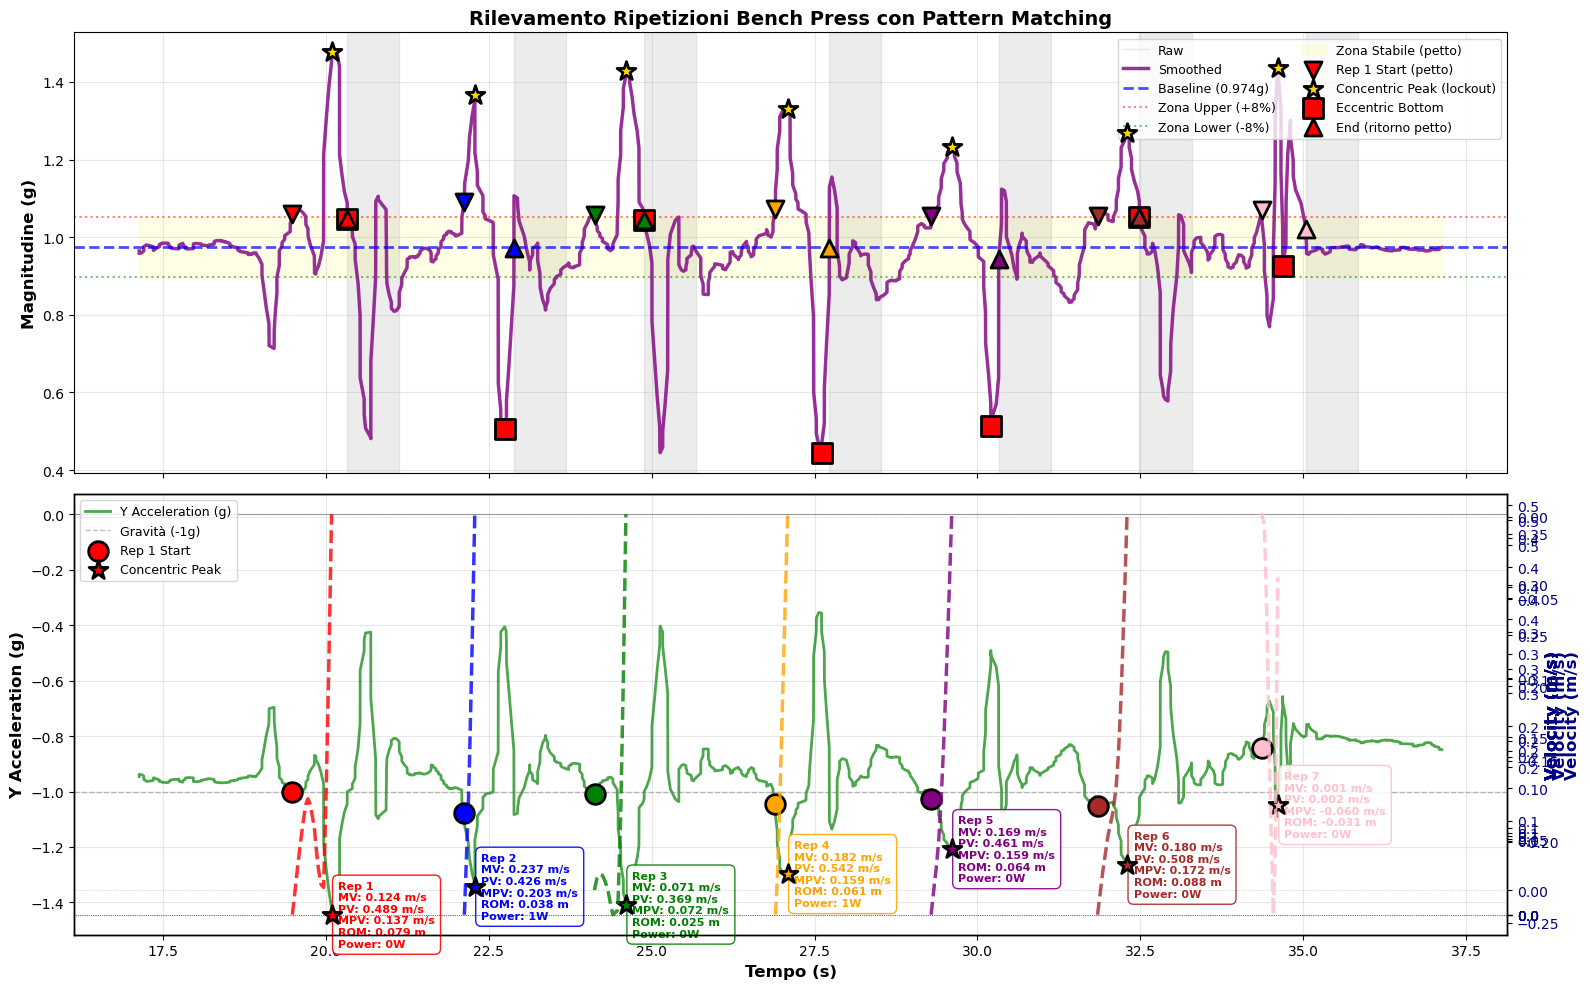

✅ Visualizzazione completata


In [ ]:
if len(valid_reps) > 0:
    # Estrai Y acceleration smoothed per il plot
    y_acc = df['Y_smooth'].values
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # SUBPLOT 1: Magnitudine con marker delle fasi
    ax1 = axes[0]
    ax1.plot(timestamps, mag, 'lightgray', alpha=0.5, linewidth=1, label='Raw')
    ax1.plot(timestamps, mag, 'purple', linewidth=2.5, label='Smoothed', alpha=0.8)
    
    # Zone baseline (pattern matching)
    ax1.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline ({baseline_value:.3f}g)', alpha=0.7)
    ax1.axhline(y=baseline_upper, color='red', linestyle=':', linewidth=1.5, label=f'Zona Upper (+{BASELINE_ZONE*100:.0f}%)', alpha=0.5)
    ax1.axhline(y=baseline_lower, color='green', linestyle=':', linewidth=1.5, label=f'Zona Lower (-{BASELINE_ZONE*100:.0f}%)', alpha=0.5)
    ax1.fill_between(timestamps, baseline_lower, baseline_upper, color='yellow', alpha=0.1, label='Zona Stabile (petto)')
    
    # Marker per ogni ripetizione
    colors_rep = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # Start (petto), Peak (lockout), Bottom (eccentrica), End - add labels only for first rep
        ax1.scatter(rep['start_time'], rep['mag_start'], s=150, marker='v', color=color, 
                   edgecolors='black', linewidths=2, zorder=10, 
                   label=f"Rep {rep['rep_num']} Start (petto)" if i == 0 else None)
        ax1.scatter(rep['concentric_peak_time'], rep['mag_peak'], s=200, marker='*', 
                   color='gold', edgecolors='black', linewidths=2, zorder=10,
                   label='Concentric Peak (lockout)' if i == 0 else None)
        ax1.scatter(rep['eccentric_bottom_time'], rep['mag_bottom'], s=200, marker='s', color='red', 
                   edgecolors='black', linewidths=2, zorder=10,
                   label='Eccentric Bottom' if i == 0 else None)
        ax1.scatter(rep['end_time'], rep['mag_end'], s=150, marker='^', color=color, 
                   edgecolors='black', linewidths=2, zorder=10,
                   label='End (ritorno petto)' if i == 0 else None)
        
        # Zona refrattaria dopo ogni rep
        refractory_end = rep['end_time'] + REFRACTORY_PERIOD
        ax1.axvspan(rep['end_time'], min(refractory_end, timestamps[-1]), 
                   color='gray', alpha=0.15, zorder=1)
    
    ax1.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
    ax1.set_title('Rilevamento Ripetizioni Bench Press con Pattern Matching', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=9, ncol=2)
    
    # SUBPLOT 2: Accelerazione Y con velocità integrata
    ax2 = axes[1]
    ax2.plot(timestamps, y_acc, 'green', linewidth=2, alpha=0.7, label='Y Acceleration (g)')
    ax2.axhline(y=-1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Gravità (-1g)')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Plot velocità per ogni ripetizione
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # Ricostruisci velocità per il plot usando magnitudine
        concentric_slice = slice(rep['start_idx'], rep['concentric_peak_idx'] + 1)
        mag_concentric = mag[concentric_slice]
        time_concentric = timestamps[concentric_slice]
        mag_accel_net = (mag_concentric - 1.0) * 9.81
        
        velocity_plot = np.zeros(len(mag_accel_net))
        for j in range(1, len(velocity_plot)):
            dt_step = time_concentric[j] - time_concentric[j-1]
            velocity_plot[j] = velocity_plot[j-1] + mag_accel_net[j] * dt_step
        
        # Plot su asse secondario
        ax2_vel = ax2.twinx()
        ax2_vel.plot(time_concentric, velocity_plot, color=color, linewidth=2.5, 
                    linestyle='--', alpha=0.8, label=f"Rep {rep['rep_num']} Velocity")
        ax2_vel.set_ylabel('Velocity (m/s)', fontweight='bold', fontsize=12, color='navy')
        ax2_vel.tick_params(axis='y', labelcolor='navy')
        ax2_vel.axhline(y=0, color='navy', linestyle=':', linewidth=0.5, alpha=0.3)
        
        # Marker start e picco concentrico
        ax2.scatter(rep['start_time'], y_acc[rep['start_idx']], s=200, marker='o', 
                   color=color, edgecolors='black', linewidths=2, zorder=10, 
                   label=f"Rep {rep['rep_num']} Start" if i == 0 else None)
        ax2.scatter(rep['concentric_peak_time'], y_acc[rep['concentric_peak_idx']], s=200, marker='*', 
                   color=color, edgecolors='black', linewidths=2, zorder=10,
                   label='Concentric Peak' if i == 0 else None)
        
        # Aggiungi testo con metriche VBT complete vicino al picco concentrico
        text_x = rep['concentric_peak_time'] + 0.1
        text_y = y_acc[rep['concentric_peak_idx']]
        metrics_text = (f"Rep {rep['rep_num']}\n"
                       f"MV: {rep['mean_velocity']:.3f} m/s\n"
                       f"PV: {rep['peak_velocity']:.3f} m/s\n"
                       f"MPV: {rep['mean_propulsive_velocity']:.3f} m/s\n"
                       f"ROM: {rep['concentric_displacement']:.3f} m\n"
                       f"Power: {rep['mean_power']:.0f}W")
        ax2.text(text_x, text_y, metrics_text,
                fontsize=8, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=color, alpha=0.9),
                verticalalignment='center')
    
    ax2.set_ylabel('Y Acceleration (g)', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizzazione completata")
else:
    print("⚠️ Nessuna ripetizione da visualizzare")

## 9. Confronto tra Ripetizioni - Analisi Velocità

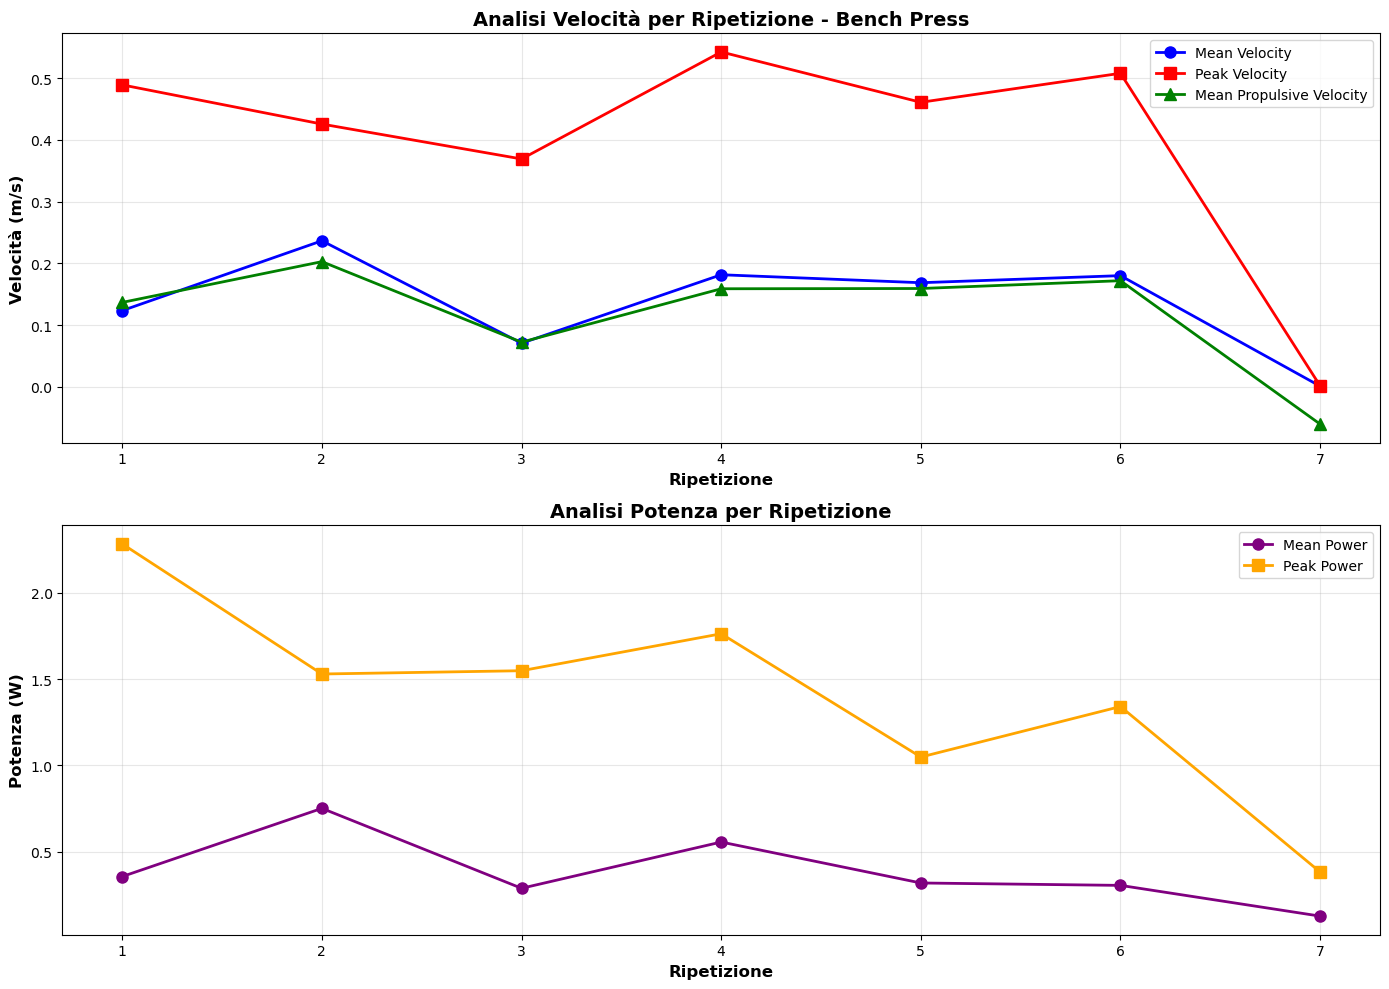

✅ Confronto ripetizioni completato


In [ ]:
if len(valid_reps) > 1:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Mean Velocity e Peak Velocity per ogni rep
    rep_nums = [r['rep_num'] for r in valid_reps]
    mean_vels = [r['mean_velocity'] for r in valid_reps]
    peak_vels = [r['peak_velocity'] for r in valid_reps]
    mpvs = [r['mean_propulsive_velocity'] for r in valid_reps]
    
    ax1 = axes[0]
    ax1.plot(rep_nums, mean_vels, 'o-', linewidth=2, markersize=8, label='Mean Velocity', color='blue')
    ax1.plot(rep_nums, peak_vels, 's-', linewidth=2, markersize=8, label='Peak Velocity', color='red')
    ax1.plot(rep_nums, mpvs, '^-', linewidth=2, markersize=8, label='Mean Propulsive Velocity', color='green')
    ax1.set_xlabel('Ripetizione', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Velocità (m/s)', fontweight='bold', fontsize=12)
    ax1.set_title('Analisi Velocità per Ripetizione - Bench Press', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_xticks(rep_nums)
    
    # Plot 2: Power per ogni rep
    mean_powers = [r['mean_power'] for r in valid_reps]
    peak_powers = [r['peak_power'] for r in valid_reps]
    
    ax2 = axes[1]
    ax2.plot(rep_nums, mean_powers, 'o-', linewidth=2, markersize=8, label='Mean Power', color='purple')
    ax2.plot(rep_nums, peak_powers, 's-', linewidth=2, markersize=8, label='Peak Power', color='orange')
    ax2.set_xlabel('Ripetizione', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Potenza (W)', fontweight='bold', fontsize=12)
    ax2.set_title('Analisi Potenza per Ripetizione', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xticks(rep_nums)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Confronto ripetizioni completato")
else:
    print("⚠️ Servono almeno 2 ripetizioni per il confronto")

## 10. Riepilogo e Conclusioni

Questo notebook ha analizzato i dati dell'accelerometro durante l'esecuzione della **bench press** identificando le fasi del movimento:

### Fasi Identificate:
1. 🔵 **Baseline Start** - Barra al petto, posizione iniziale
2. 🚀 **Fase Concentrica** - Spinta esplosiva verso l'alto
3. ⭐ **Lockout** - Posizione superiore, massima estensione
4. 🔻 **Fase Eccentrica** - Discesa controllata della barra
5. 🔵 **Baseline End** - Ritorno al petto

### Marker sui Grafici:
- **Triangoli giù** (▼) = Start (petto)
- **Stelle dorate** (★) = Concentric Peak (lockout)
- **Quadrati rossi** (■) = Eccentric Bottom
- **Triangoli su** (▲) = End (ritorno al petto)

### Metriche VBT Calcolate:
✅ **Mean Velocity (MV)** - Velocità media nella fase concentrica  
✅ **Peak Velocity (PV)** - Velocità massima raggiunta  
✅ **Mean Propulsive Velocity (MPV)** - Velocità media nella fase propulsiva (accel > 0)  
✅ **Mean Power** - Potenza media  
✅ **Peak Power** - Potenza massima  
✅ **ROM** - Range of Motion (spostamento)  
✅ **Velocity Loss (VL%)** - Perdita di velocità tra prima e ultima ripetizione (indicatore di fatica)

### Analisi Completata:
✅ Identificazione automatica delle fasi della bench press  
✅ Marker visualizzati per ogni transizione di fase  
✅ Calcolo metriche VBT complete per ogni ripetizione  
✅ Statistiche aggregate e analisi del velocity loss  
✅ Confronto tra ripetizioni per monitorare la fatica

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# Configurazione per grafici più grandi e leggibili
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dati

In [ ]:
# Carica il file CSV
filename = 'accel_data_20251120_152715.csv'

df = pd.read_csv(filename)

# Mostra le prime righe
print(f"📊 Dataset caricato: {len(df)} campioni")
print(f"⏱️  Durata: {df['Timestamp'].max() - df['Timestamp'].min():.2f} secondi")
print(f"📈 Frequenza di campionamento: ~{len(df)/(df['Timestamp'].max() - df['Timestamp'].min()):.1f} Hz\n")

# Statistiche di base
print("Statistiche Magnitudine:")
print(df['Magnitude (g)'].describe())
print(f"\n📏 Range: {df['Magnitude (g)'].min():.4f}g - {df['Magnitude (g)'].max():.4f}g")

df.head(10)

📊 Dataset caricato: 1020 campioni
⏱️  Durata: 19.96 secondi
📈 Frequenza di campionamento: ~51.1 Hz

Statistiche Magnitudine:
count    1020.000000
mean        0.967124
std         0.126208
min         0.398361
25%         0.945797
50%         0.973025
75%         0.993878
max         1.463838
Name: Magnitude (g), dtype: float64

📏 Range: 0.3984g - 1.4638g


,Timestamp,X (g),Y (g),Z (g),Magnitude (g)
0,17.544,0.140625,-1.000000,-0.031250,1.010323
1,17.546,0.140625,-0.968750,-0.031250,0.979402
2,17.548,0.109375,-0.968750,-0.046875,0.976031
3,17.581,0.109375,-0.968750,-0.046875,0.976031
4,17.582,0.140625,-0.968750,-0.062500,0.980897
5,17.584,0.171875,-0.953125,-0.078125,0.971644
6,17.623,0.156250,-0.937500,-0.109375,0.956704
7,17.624,0.156250,-0.937500,-0.125000,0.958616
8,17.665,0.187500,-0.921875,-0.093750,0.945409
9,17.701,0.171875,-0.921875,-0.093750,0.942435


## 3. Visualizzazione Dati Grezzi

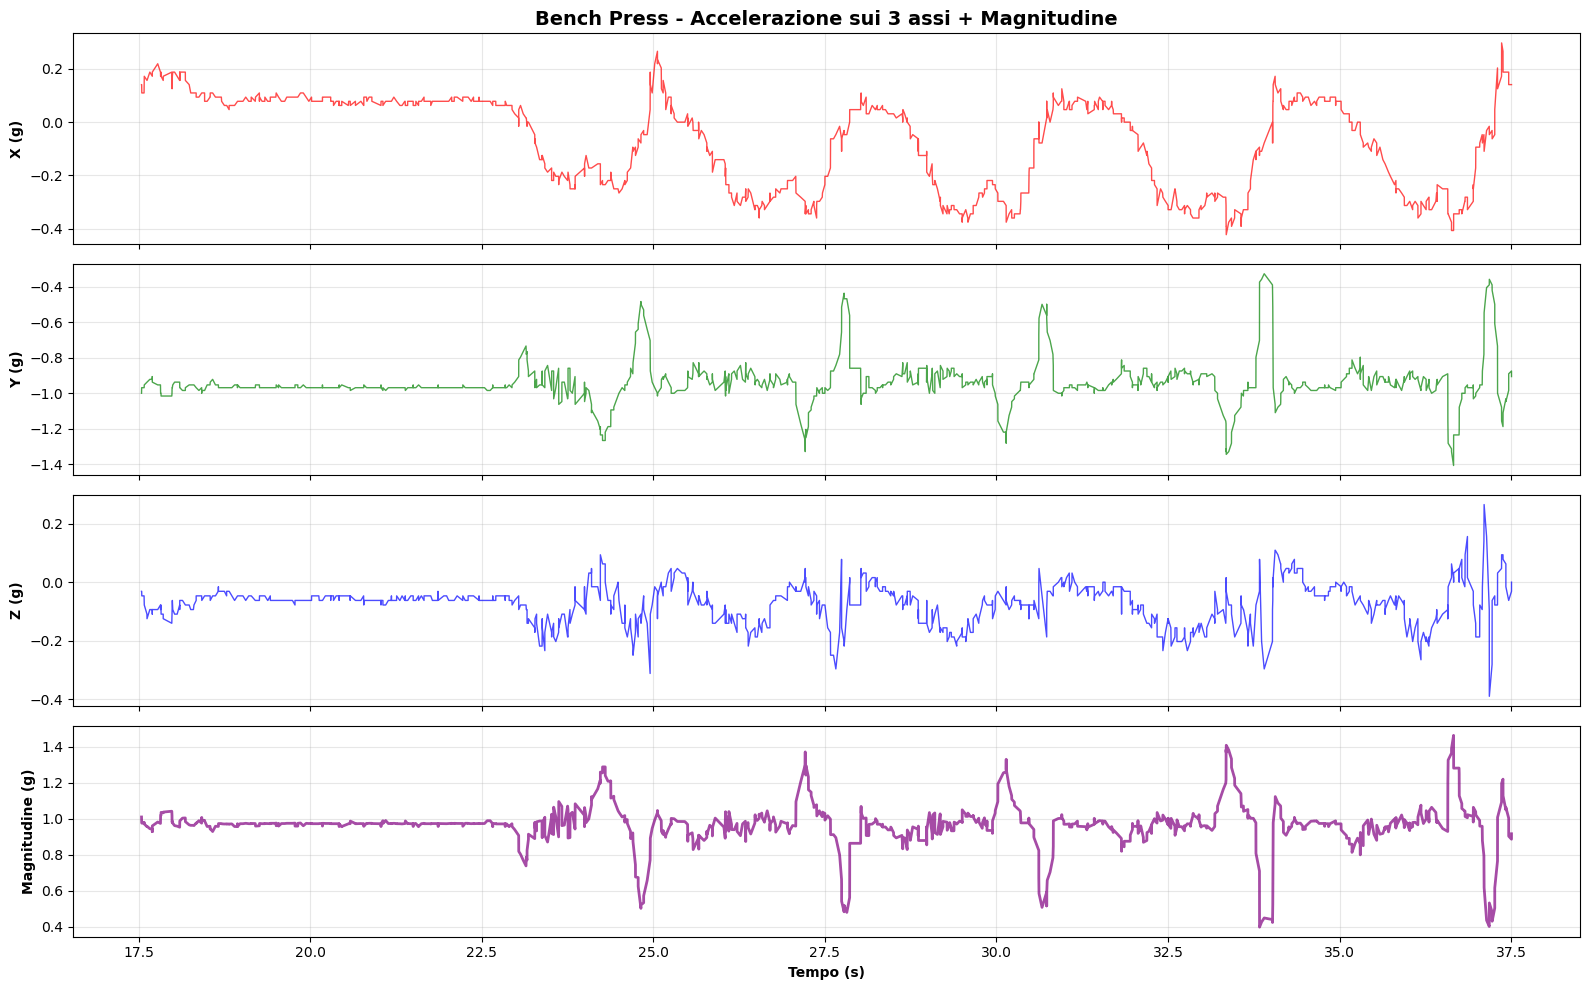

🔍 Nota: Osserva il pattern di magnitudine - descrive chiaramente il movimento di discesa e salita del bilanciere


In [ ]:
# Plot dei dati grezzi
fig, axes = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

axes[0].plot(df['Timestamp'], df['X (g)'], 'r-', alpha=0.7, linewidth=1)
axes[0].set_ylabel('X (g)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Bench Press - Accelerazione sui 3 assi + Magnitudine', fontsize=14, fontweight='bold')

axes[1].plot(df['Timestamp'], df['Y (g)'], 'g-', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Y (g)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Timestamp'], df['Z (g)'], 'b-', alpha=0.7, linewidth=1)
axes[2].set_ylabel('Z (g)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['Timestamp'], df['Magnitude (g)'], 'purple', linewidth=2, alpha=0.7)
axes[3].set_ylabel('Magnitudine (g)', fontweight='bold')
axes[3].set_xlabel('Tempo (s)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 Nota: Osserva il pattern di magnitudine - descrive chiaramente il movimento di discesa e salita del bilanciere")

## 4. Smoothing e Preprocessing

In [ ]:
# Applica smoothing gaussiano per ridurre il rumore
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sigma = 2  # Parametro di smoothing

df['X_smooth'] = gaussian_filter1d(df['X (g)'], sigma=sigma)
df['Y_smooth'] = gaussian_filter1d(df['Y (g)'], sigma=sigma)
df['Z_smooth'] = gaussian_filter1d(df['Z (g)'], sigma=sigma)
df['Mag_smooth'] = gaussian_filter1d(df['Magnitude (g)'], sigma=sigma)

# Calcola la derivata (velocità) della magnitudine per identificare cambiamenti
df['Mag_velocity'] = np.gradient(df['Mag_smooth'], df['Timestamp'])
df['Mag_velocity_smooth'] = gaussian_filter1d(df['Mag_velocity'], sigma=sigma)

print("✅ Smoothing applicato con successo")
print(f"📊 Velocità magnitudine - Range: {df['Mag_velocity'].min():.2f} to {df['Mag_velocity'].max():.2f} g/s")

✅ Smoothing applicato con successo
📊 Velocità magnitudine - Range: -inf to 96.03 g/s


## 5. Identificazione Baseline (Lockout)

Il baseline rappresenta la posizione di lockout con le braccia estese.
Utilizziamo i primi 2 secondi di dati per stabilire il riferimento.

In [ ]:
# Identifica baseline dai primi 2 secondi
baseline_duration = 2.0
baseline_mask = df['Timestamp'] < (df['Timestamp'].min() + baseline_duration)

baseline_mag_mean = df.loc[baseline_mask, 'Magnitude (g)'].mean()
baseline_mag_std = df.loc[baseline_mask, 'Magnitude (g)'].std()
baseline_mag_min = baseline_mag_mean - 2 * baseline_mag_std
baseline_mag_max = baseline_mag_mean + 2 * baseline_mag_std

print("="*60)
print("BASELINE (LOCKOUT POSITION)")
print("="*60)
print(f"Mean:     {baseline_mag_mean:.4f}g")
print(f"Std Dev:  {baseline_mag_std:.4f}g")
print(f"Range:    {baseline_mag_min:.4f}g - {baseline_mag_max:.4f}g")
print(f"Samples:  {baseline_mask.sum()}")
print("\n🔒 Questa è la magnitudine quando il bilanciere è in lockout (braccia estese)")

BASELINE (LOCKOUT POSITION)
Mean:     0.9758g
Std Dev:  0.0205g
Range:    0.9349g - 1.0168g
Samples:  104

🔒 Questa è la magnitudine quando il bilanciere è in lockout (braccia estese)


## 6. Rilevamento Rep Bottoms (Chest Touch)

Identifichiamo i punti di minima magnitudine che corrispondono al tocco del bilanciere sul petto.

In [ ]:
# Trova i minimi locali (chest touch points)
# Inverti il segnale per trovare i minimi come picchi
inverted_mag = -df['Mag_smooth'].values

# Parametri ottimizzati per bench press
prominence = 0.05  # Differenza minima per essere considerato un rep
min_distance = 50  # Distanza minima tra reps (~1 secondo a 50Hz)

bottoms_idx, bottom_properties = find_peaks(inverted_mag, 
                                             prominence=prominence, 
                                             distance=min_distance)

print("="*60)
print(f"REP BOTTOMS DETECTED: {len(bottoms_idx)}")
print("="*60)

# Crea DataFrame con dettagli dei bottoms
bottoms_df = pd.DataFrame({
    'Rep': range(1, len(bottoms_idx) + 1),
    'Time (s)': df.loc[bottoms_idx, 'Timestamp'].values,
    'Magnitude (g)': df.loc[bottoms_idx, 'Magnitude (g)'].values,
    'Depth from Baseline': baseline_mag_mean - df.loc[bottoms_idx, 'Magnitude (g)'].values
})

print(bottoms_df.to_string(index=False))
print(f"\n📊 Profondità media: {bottoms_df['Depth from Baseline'].mean():.4f}g")
print(f"📊 Magnitudine media al bottom: {bottoms_df['Magnitude (g)'].mean():.4f}g")

REP BOTTOMS DETECTED: 8
 Rep  Time (s)  Magnitude (g)  Depth from Baseline
   1    23.146       0.738684             0.237137
   2    24.821       0.521510             0.454311
   3    27.781       0.519399             0.456422
   4    30.732       0.570045             0.405776
   5    31.823       0.844473             0.131348
   6    33.901       0.449338             0.526483
   7    35.225       0.863484             0.112337
   8    37.181       0.532856             0.442965

📊 Profondità media: 0.3458g
📊 Magnitudine media al bottom: 0.6300g


## 7. Rilevamento Picchi Concentrici

I picchi di magnitudine durante la fase concentrica indicano l'accelerazione esplosiva del bilanciere.

In [ ]:
# Trova i picchi (concentric power)
peaks_idx, peak_properties = find_peaks(df['Mag_smooth'].values, 
                                        prominence=prominence, 
                                        distance=min_distance)

print("="*60)
print(f"CONCENTRIC PEAKS DETECTED: {len(peaks_idx)}")
print("="*60)

# Crea DataFrame con dettagli dei picchi
peaks_df = pd.DataFrame({
    'Peak': range(1, len(peaks_idx) + 1),
    'Time (s)': df.loc[peaks_idx, 'Timestamp'].values,
    'Magnitude (g)': df.loc[peaks_idx, 'Magnitude (g)'].values,
    'Power above Baseline': df.loc[peaks_idx, 'Magnitude (g)'].values - baseline_mag_mean
})

print(peaks_df.to_string(index=False))
print(f"\n💪 Potenza media: {peaks_df['Power above Baseline'].mean():.4f}g sopra baseline")
print(f"💪 Picco massimo: {peaks_df['Magnitude (g)'].max():.4f}g")

CONCENTRIC PEAKS DETECTED: 8
 Peak  Time (s)  Magnitude (g)  Power above Baseline
    1    17.860       1.033378              0.057557
    2    24.261       1.288660              0.312839
    3    25.304       1.000610              0.024789
    4    27.214       1.371889              0.396068
    5    30.142       1.330788              0.354967
    6    32.341       1.035031              0.059210
    7    33.348       1.408765              0.432944
    8    36.660       1.463838              0.488017

💪 Potenza media: 0.2658g sopra baseline
💪 Picco massimo: 1.4638g


## 8. Calcolo Durate Rep

Analizza la durata di ogni ripetizione (da bottom a bottom successivo).

In [ ]:
if len(bottoms_idx) > 1:
    # Calcola durate tra bottoms consecutivi
    rep_times = df.loc[bottoms_idx, 'Timestamp'].values
    rep_durations = np.diff(rep_times)
    
    print("="*60)
    print("REP TIMING ANALYSIS")
    print("="*60)
    print(f"Numero di reps: {len(bottoms_idx)}")
    print(f"Numero di intervalli: {len(rep_durations)}")
    print(f"\nDurata media rep: {rep_durations.mean():.2f}s")
    print(f"Durata minima rep: {rep_durations.min():.2f}s")
    print(f"Durata massima rep: {rep_durations.max():.2f}s")
    print(f"Deviazione standard: {rep_durations.std():.2f}s")
    
    print("\n📊 Durate individuali (secondi):")
    for i, duration in enumerate(rep_durations):
        print(f"  Rep {i+1} → Rep {i+2}: {duration:.2f}s")
else:
    print("⚠️  Non abbastanza reps per calcolare le durate")

REP TIMING ANALYSIS
Numero di reps: 8
Numero di intervalli: 7

Durata media rep: 2.00s
Durata minima rep: 1.09s
Durata massima rep: 2.96s
Deviazione standard: 0.68s

📊 Durate individuali (secondi):
  Rep 1 → Rep 2: 1.68s
  Rep 2 → Rep 3: 2.96s
  Rep 3 → Rep 4: 2.95s
  Rep 4 → Rep 5: 1.09s
  Rep 5 → Rep 6: 2.08s
  Rep 6 → Rep 7: 1.32s
  Rep 7 → Rep 8: 1.96s


## 9. Rilevamento Fasi Complete

Identifichiamo tutte le fasi di ogni ripetizione (pattern identico allo squat):
1. **Baseline/Lockout** - Posizione di partenza in alto (come lo squat parte da piedi)
2. **Eccentric Start** - Inizio discesa verso il petto (velocità negativa)
3. **Bottom/Chest Touch** - Tocco al petto, punto più basso (magnitudine minima)
4. **Concentric Start** - Inizio spinta esplosiva verso l'alto (velocità positiva)
5. **Concentric Peak** - Picco di accelerazione/potenza durante la spinta
6. **Rebound** - ⚠️ Oscillazione dell'accelerometro dopo il picco (NON è movimento reale!)
7. **Return to Lockout** - Ritorno alla posizione alta di partenza

In [ ]:
# Definisci soglie per il rilevamento delle fasi
VELOCITY_THRESHOLD = 0.5  # g/s per rilevare inizio movimento

# Inizializza lista per memorizzare le fasi
phases = []
current_phase = 'BASELINE'
phase_start_idx = 0

# Soglie per identificare le fasi
BASELINE_LOWER = baseline_mag_mean - baseline_mag_std
BASELINE_UPPER = baseline_mag_mean + baseline_mag_std

for i in range(len(df)):
    mag = df.loc[i, 'Mag_smooth']
    vel = df.loc[i, 'Mag_velocity_smooth']
    
    if current_phase == 'BASELINE':
        # Cerca inizio discesa (velocità negativa significativa)
        if vel < -VELOCITY_THRESHOLD and mag < BASELINE_LOWER:
            phases.append({
                'phase': current_phase,
                'start_idx': phase_start_idx,
                'end_idx': i,
                'duration': df.loc[i, 'Timestamp'] - df.loc[phase_start_idx, 'Timestamp']
            })
            current_phase = 'ECCENTRIC'
            phase_start_idx = i
    
    elif current_phase == 'ECCENTRIC':
        # Cerca bottom (magnitudine molto bassa + velocità vicina a zero)
        if abs(vel) < VELOCITY_THRESHOLD and mag < 0.7:
            phases.append({
                'phase': current_phase,
                'start_idx': phase_start_idx,
                'end_idx': i,
                'duration': df.loc[i, 'Timestamp'] - df.loc[phase_start_idx, 'Timestamp']
            })
            current_phase = 'BOTTOM'
            phase_start_idx = i
    
    elif current_phase == 'BOTTOM':
        # Cerca inizio concentrica (velocità positiva)
        if vel > VELOCITY_THRESHOLD:
            phases.append({
                'phase': current_phase,
                'start_idx': phase_start_idx,
                'end_idx': i,
                'duration': df.loc[i, 'Timestamp'] - df.loc[phase_start_idx, 'Timestamp']
            })
            current_phase = 'CONCENTRIC'
            phase_start_idx = i
    
    elif current_phase == 'CONCENTRIC':
        # Cerca ritorno a baseline (magnitudine torna al baseline range)
        if mag > BASELINE_LOWER and mag < BASELINE_UPPER and abs(vel) < VELOCITY_THRESHOLD:
            phases.append({
                'phase': current_phase,
                'start_idx': phase_start_idx,
                'end_idx': i,
                'duration': df.loc[i, 'Timestamp'] - df.loc[phase_start_idx, 'Timestamp']
            })
            current_phase = 'BASELINE'
            phase_start_idx = i

# Aggiungi l'ultima fase
phases.append({
    'phase': current_phase,
    'start_idx': phase_start_idx,
    'end_idx': len(df) - 1,
    'duration': df.loc[len(df)-1, 'Timestamp'] - df.loc[phase_start_idx, 'Timestamp']
})

# Crea DataFrame delle fasi
phases_df = pd.DataFrame(phases)

print("="*60)
print(f"FASI RILEVATE: {len(phases_df)}")
print("="*60)
print(phases_df[['phase', 'duration']].to_string(index=False))

# Statistiche per fase
print("\n📊 Statistiche per Fase:")
phase_stats = phases_df.groupby('phase')['duration'].agg(['count', 'mean', 'std', 'min', 'max'])
print(phase_stats)

FASI RILEVATE: 1
   phase  duration
BASELINE     19.96

📊 Statistiche per Fase:
          count   mean  std    min    max
phase                                    
BASELINE      1  19.96  NaN  19.96  19.96


## 9b. Analisi Rebound Effect (Rinculo Post-Lockout)

⚠️ **FENOMENO CRITICO**: Dopo il lockout al top, l'accelerometro registra DUE dip distinti!

**SEQUENZA CORRETTA:**
```
1. Concentric Peak 🟢 (lockout al top - alta magnitudine)
      ↓
2. Ritorno verso baseline (discesa rapida)
      ↓
3. Rebound Spike ⚠️ (PRIMO dip - FALSO!)
   └─ Artefatto da frenata brusca al lockout
      ↓
4. Piccola risalita (stabilizzazione ~0.1s)
      ↓
5. Chest Touch 🎯 (SECONDO dip - VERO tocco sul petto!)
   └─ Piccolo "su-giù" che rappresenta il tocco reale
      ↓
6. Inizio nuova concentrica
```

**IMPORTANTE:** Il rebound è il PRIMO dip (falso), il chest touch è il SECONDO dip (vero)!

In [ ]:
""" ALGORITMO SEQUENZIALE CORRETTO PER BENCH PRESS

LOGICA CORRETTA:
1. CLOSED REPS (triangolo rosso) = Attraversamento baseline verso il basso (inizio movimento)
2. CHEST TOUCHES (X arancione) = Dip profondo (tocco del petto vero)  
3. CONCENTRIC PEAK (triangolo verde) = Picco concentrico (lockout)
4. REBOUND SPIKES (pallino blu) = Bottoms originali (minimi rilevati)

SEQUENZA CORRETTA:
CLOSED REPS (baseline break) → CHEST TOUCHES (dip profondo) → CONCENTRIC PEAK → REBOUND SPIKES (bottoms)
"""

print("="*90)
print("🔍 ALGORITMO SEQUENZIALE - Validazione Rep Completa")
print("="*90)

# Parametri CORRETTI per la logica invertita
BASELINE_THRESHOLD = baseline_mag_mean - (0.8 * baseline_mag_std)  # Soglia per attraversamento baseline
MIN_TIME_IN_BASELINE = 0.3  # Tempo minimo in baseline prima di nuovo attraversamento
POST_RETURN_DEAD_TIME = 0.5  # Tempo morto dopo baseline return
CHEST_TOUCH_SEARCH_WINDOW = 2.0  # Finestra per trovare dip profondo (chest touch)
PEAK_SEARCH_WINDOW = 4.0   # Finestra per trovare peak
RETURN_SEARCH_WINDOW = 4.0  # Finestra per ritorno baseline
MIN_CHEST_TOUCH_DEPTH = 0.12  # Profondità minima per dip profondo (chest touch)
MIN_BASELINE_BREAK_DROP = 0.02  # Drop minimo per attraversamento baseline

print(f"📊 PARAMETRI CORRETTI:")
print(f"  • Baseline threshold: {BASELINE_THRESHOLD:.4f}g")
print(f"  • Baseline mean: {baseline_mag_mean:.4f}g")
print(f"  • Min time in baseline: {MIN_TIME_IN_BASELINE}s")
print(f"  • Post-return dead time: {POST_RETURN_DEAD_TIME}s")
print(f"  • Min chest touch depth: {MIN_CHEST_TOUCH_DEPTH:.3f}g")
print(f"  • Chest touch search window: {CHEST_TOUCH_SEARCH_WINDOW}s")
print(f"  • Peak search window: {PEAK_SEARCH_WINDOW}s")

# Strutture per memorizzare rep complete
validated_reps = []        # Rep con ciclo COMPLETO
current_rep = None
state = 'SEEKING_CLOSED_REP'  # Inizia cercando attraversamento baseline (closed rep)
last_baseline_time = 0

print(f"\n🔄 PROCESSAMENTO SEQUENZIALE CORRETTO:")
print(f"  1. BASELINE BREAK → Closed Reps (triangolo rosso)")
print(f"  2. CHEST TOUCHES → Dip profondo (X arancione)")  
print(f"  3. CONCENTRIC PEAK → Lockout (triangolo verde)")
print(f"  4. REBOUND SPIKES → Bottoms originali (minimi)")
print()

for i in range(len(df)):
    timestamp = df.loc[i, 'Timestamp']
    mag = df.loc[i, 'Mag_smooth']
    
    # STATE 1: Cerco attraversamento baseline (CLOSED REP = triangolo rosso)
    if state == 'SEEKING_CLOSED_REP':
        # Verifica di essere in baseline abbastanza a lungo
        if mag >= baseline_mag_mean - baseline_mag_std:
            last_baseline_time = timestamp
        
        # Cerca attraversamento baseline verso il basso (CLOSED REP)
        elif mag < BASELINE_THRESHOLD and (timestamp - last_baseline_time) >= MIN_TIME_IN_BASELINE:
            # Inizia nuova rep con closed rep
            current_rep = {
                'closed_rep_idx': i,
                'closed_rep_time': timestamp,
                'closed_rep_mag': mag,
            }
            
            state = 'SEEKING_CHEST_TOUCH'
            print(f"   🔴 CLOSED REP #{len(validated_reps)+1} at {timestamp:.2f}s")
    
    # STATE 2: Cerco CHEST TOUCH (DIP PROFONDO = X arancione)  
    elif state == 'SEEKING_CHEST_TOUCH':
        # Timeout: se non trovo dip profondo entro il tempo limite, reset
        if timestamp - current_rep['closed_rep_time'] > CHEST_TOUCH_SEARCH_WINDOW:
            print(f"   ❌ Timeout chest touch per rep #{len(validated_reps)+1}")
            state = 'SEEKING_CLOSED_REP'
            current_rep = None
            continue
        
        # Cerca dip profondo (chest touch)
        if timestamp > current_rep['closed_rep_time']:
            # Controlla se siamo in un dip significativo
            depth_from_baseline = baseline_mag_mean - mag
            if depth_from_baseline >= MIN_CHEST_TOUCH_DEPTH:
                # Trova il punto di massima profondità in una piccola finestra
                search_end = min(i + 15, len(df))  # cerca nei prossimi ~0.3s
                search_indices = range(i, search_end)
                touch_idx = min(search_indices, key=lambda idx: df.loc[idx, 'Mag_smooth'])
                
                current_rep['chest_touch_idx'] = touch_idx
                current_rep['chest_touch_time'] = df.loc[touch_idx, 'Timestamp']
                current_rep['chest_touch_mag'] = df.loc[touch_idx, 'Mag_smooth']
                current_rep['chest_touch_depth'] = baseline_mag_mean - df.loc[touch_idx, 'Mag_smooth']
                
                state = 'SEEKING_PEAK'
                print(f"     🟠 CHEST TOUCH at {current_rep['chest_touch_time']:.2f}s (depth: {current_rep['chest_touch_depth']:.3f}g)")
    
    # STATE 3: Cerco CONCENTRIC PEAK (triangolo verde)
    elif state == 'SEEKING_PEAK':
        # Timeout: se non trovo peak entro il tempo limite, reset
        if timestamp - current_rep['chest_touch_time'] > PEAK_SEARCH_WINDOW:
            print(f"   ❌ Timeout peak per rep #{len(validated_reps)+1}")
            state = 'SEEKING_CLOSED_REP'
            current_rep = None
            continue
        
        # Cerca picchi nel range temporale dopo chest touch
        peak_candidates = [(idx, df.loc[idx, 'Mag_smooth']) for idx in peaks_idx 
                          if df.loc[idx, 'Timestamp'] > current_rep['chest_touch_time'] and
                             df.loc[idx, 'Timestamp'] <= timestamp]
        
        if peak_candidates:
            # Prendi il peak più alto in questo range
            peak_idx, peak_mag = max(peak_candidates, key=lambda x: x[1])
            current_rep['peak_idx'] = peak_idx
            current_rep['peak_time'] = df.loc[peak_idx, 'Timestamp']
            current_rep['peak_mag'] = peak_mag
            current_rep['concentric_duration'] = current_rep['peak_time'] - current_rep['chest_touch_time']
            
            state = 'SEEKING_REBOUND_SPIKE'
            print(f"     🟢 CONCENTRIC PEAK at {current_rep['peak_time']:.2f}s (dopo {current_rep['concentric_duration']:.2f}s)")
    
    # STATE 4: Cerco REBOUND SPIKE (bottom originale)
    elif state == 'SEEKING_REBOUND_SPIKE':
        # Timeout per rebound spike  
        if timestamp - current_rep['peak_time'] > RETURN_SEARCH_WINDOW:
            print(f"   ❌ Timeout rebound spike per rep #{len(validated_reps)+1}")
            state = 'SEEKING_CLOSED_REP'
            current_rep = None
            continue
        
        # Cerca tra i bottoms originali quello più vicino dopo il peak
        for bottom_idx in bottoms_idx:
            bottom_time = df.loc[bottom_idx, 'Timestamp']
            if bottom_time > current_rep['peak_time'] and bottom_time <= timestamp:
                # REP COMPLETAMENTE VALIDATA!
                current_rep['rebound_spike_idx'] = bottom_idx
                current_rep['rebound_spike_time'] = bottom_time
                current_rep['rebound_spike_mag'] = df.loc[bottom_idx, 'Mag_smooth']
                current_rep['total_duration'] = bottom_time - current_rep['closed_rep_time']
                
                validated_reps.append(current_rep)
                print(f"     🔵 REBOUND SPIKE #{len(validated_reps)} at {bottom_time:.2f}s (durata totale: {current_rep['total_duration']:.2f}s)")
                
                state = 'SEEKING_CLOSED_REP'
                current_rep = None
                # IMPORTANTE: Imposta tempo morto per evitare eventi spurii
                last_baseline_time = timestamp + POST_RETURN_DEAD_TIME
                break

# Converti in DataFrame per analisi
validated_reps_df = pd.DataFrame(validated_reps)
all_reps_df = validated_reps_df

print(f"  • Sequenza: CLOSED REPS → CHEST TOUCHES → CONCENTRIC PEAK → REBOUND SPIKES")
print(f"  • ✅ REP COMPLETE: {len(validated_reps_df)}")
print(f"  • Sequenza: BASELINE BREAK → REBOUND SPIKE → CONCENTRIC PEAK → BASELINE RETURN")
print(f"  • 🎯 TOTALE REP RILEVATE: {len(all_reps_df)}")

# Mostra rep complete con LOGICA CORRETTA
if len(validated_reps_df) > 0:
    print(f"\n✅ REP COMPLETE:")
    print(f"{'Rep #':<6} {'Closed':<12} {'Chest':<8} {'Peak':<10} {'Rebound':<12} {'Durata':<8} {'Depth':<8}")
    print("-" * 75)
    
    for i, row in validated_reps_df.iterrows():
        print(f"  C{i+1:<3} "
              f"{row['closed_rep_time']:.2f}s{'':<6} "
              f"{row['chest_touch_time']:.2f}s{'':<2} "
              f"{row['peak_time']:.2f}s{'':<4} "
              f"{row['rebound_spike_time']:.2f}s{'':<6} "
              f"{row['total_duration']:.2f}s{'':<2} "
              f"{row['chest_touch_depth']:.3f}g")

# La nuova logica non ha rep parziali - solo rep complete con tutti i 4 eventi

# Statistiche combinate
if len(all_reps_df) > 0:
    print(f"\n{'Rep #':<6} {'Closed':<12} {'Chest':<8} {'Peak':<10} {'Rebound':<12} {'Durata':<8} {'Depth':<8}")
    print("-" * 75)
    
    for i, row in validated_reps_df.iterrows():
        print(f"  {i+1:<4} "
              f"{row['closed_rep_time']:.2f}s{'':<6} "
              f"{row['chest_touch_time']:.2f}s{'':<2} "
              f"{row['peak_time']:.2f}s{'':<4} "
              f"{row['rebound_spike_time']:.2f}s{'':<6} "
              f"{row['total_duration']:.2f}s{'':<2} "
              f"{row['chest_touch_depth']:.3f}g")
    
    print(f"\n📊 STATISTICHE REP VALIDATE:")
    print(f"  • Durata media rep: {validated_reps_df['total_duration'].mean():.2f}s ± {validated_reps_df['total_duration'].std():.2f}s")
    print(f"  • Durata concentrica media: {validated_reps_df['concentric_duration'].mean():.2f}s ± {validated_reps_df['concentric_duration'].std():.2f}s")
    print(f"  • Profondità chest touch media: {validated_reps_df['chest_touch_depth'].mean():.3f}g ± {validated_reps_df['chest_touch_depth'].std():.3f}g")
    
    # Confronto con detection precedente
    print(f"\n🔍 CONFRONTO METODI:")
    print(f"  • Bottoms originali rilevati: {len(bottoms_idx)}")
    print(f"  • Peaks concentrici: {len(peaks_idx)}")
    print(f"  • Rep validate (ciclo completo): {len(validated_reps_df)}")
    
    # Efficienza di validazione
    validation_rate = (len(validated_reps_df) / len(bottoms_idx)) * 100 if len(bottoms_idx) > 0 else 0
    print(f"  • Tasso di validazione: {validation_rate:.1f}% (rep complete su bottoms rilevati)")

else:
    print("⚠️  Nessuna rep completa validata con questo algoritmo")

# Estrai i componenti con la NUOVA LOGICA CORRETTA
if len(all_reps_df) > 0:
    # Non c'è più bisogno di chest_touch_df separato - tutto è in validated_reps_df
    # I dataframe sono già pronti per la visualizzazione
    pass
else:
    # Dataframe vuoti se non ci sono rep
    pass

print("\n" + "="*90)
print("✅ ALGORITMO IBRIDO COMPLETATO:")
print("  • 🎯 Prima rottura baseline → CHEST TOUCH (sempre rilevato)")
print("  • ▲ Picco concentrico → PEAK (sempre rilevato)")  
print("  • ❌ Primo dip dopo peak → REBOUND (se presente)")
print("  • 🔵 Ritorno baseline → VALIDATION (se presente)")

print("  • Rep COMPLETE: ciclo completo | Rep PARZIALI: chest + peak validi")
print("="*90)

🔍 ALGORITMO SEQUENZIALE - Validazione Rep Completa
📊 PARAMETRI CORRETTI:
  • Baseline threshold: 0.9594g
  • Baseline mean: 0.9758g
  • Min time in baseline: 0.3s
  • Post-return dead time: 0.5s
  • Min chest touch depth: 0.120g
  • Chest touch search window: 2.0s
  • Peak search window: 4.0s

🔄 PROCESSAMENTO SEQUENZIALE CORRETTO:
  1. BASELINE BREAK → Closed Reps (triangolo rosso)
  2. CHEST TOUCHES → Dip profondo (X arancione)
  3. CONCENTRIC PEAK → Lockout (triangolo verde)
  4. REBOUND SPIKES → Bottoms originali (minimi)

   🔴 CLOSED REP #1 at 23.27s
     🟠 CHEST TOUCH at 24.82s (depth: 0.400g)
     🟢 CONCENTRIC PEAK at 25.30s (dopo 0.48s)
     🔵 REBOUND SPIKE #1 at 27.78s (durata totale: 4.51s)
   🔴 CLOSED REP #2 at 28.66s
     🟠 CHEST TOUCH at 30.73s (depth: 0.398g)
     🔵 REBOUND SPIKE #1 at 27.78s (durata totale: 4.51s)
   🔴 CLOSED REP #2 at 28.66s
     🟠 CHEST TOUCH at 30.73s (depth: 0.398g)
     🟢 CONCENTRIC PEAK at 32.34s (dopo 1.61s)
     🔵 REBOUND SPIKE #2 at 33.90s (durat

In [ ]:
# DEBUG: Analizziamo tutti i dip per capire depth e timing

print("="*80)
print("🔍 DEBUG: Analisi di TUTTI i dip per calibrare parametri")
print("="*80)

# Trova TUTTI i dip sotto la baseline threshold
all_dips = []
for i in range(len(df)):
    mag = df.loc[i, 'Mag_smooth']
    timestamp = df.loc[i, 'Timestamp']
    
    if mag < BASELINE_THRESHOLD:
        # Trova il minimo locale intorno a questo punto
        search_start = max(0, i - 15)
        search_end = min(len(df), i + 15)
        local_min_idx = df.loc[search_start:search_end, 'Mag_smooth'].idxmin()
        
        # Evita duplicati (se siamo già vicini a un minimo registrato)
        if not any(abs(local_min_idx - dip['idx']) < 20 for dip in all_dips):
            depth = baseline_mag_mean - df.loc[local_min_idx, 'Mag_smooth']
            all_dips.append({
                'idx': local_min_idx,
                'time': df.loc[local_min_idx, 'Timestamp'],
                'magnitude': df.loc[local_min_idx, 'Mag_smooth'],
                'depth': depth
            })

# Ordina per tempo
all_dips.sort(key=lambda x: x['time'])

print(f"📊 TUTTI I DIP RILEVATI: {len(all_dips)}")
print()
print(f"{'#':<3} {'Time':<8} {'Magnitude':<12} {'Depth':<10} {'Tipo Candidato'}")
print("-" * 55)

for i, dip in enumerate(all_dips):
    tipo = ""
    if dip['depth'] >= MIN_CHEST_TOUCH_DEPTH:
        tipo = "CHEST TOUCH"
    elif dip['depth'] >= 0.05:
        tipo = "REBOUND?"
    else:
        tipo = "Rumore"
    
    print(f"{i+1:<3} {dip['time']:<8.2f} {dip['magnitude']:<12.4f} {dip['depth']:<10.4f} {tipo}")

# Statistiche
depths = [dip['depth'] for dip in all_dips]
print(f"\n📊 STATISTICHE PROFONDITÀ:")
print(f"  • Profondità media: {np.mean(depths):.4f}g")
print(f"  • Profondità minima: {np.min(depths):.4f}g")
print(f"  • Profondità massima: {np.max(depths):.4f}g")
print(f"  • Soglia attuale chest touch: {MIN_CHEST_TOUCH_DEPTH:.3f}g")

# Conta quanti superano la soglia
valid_chest_touches = [dip for dip in all_dips if dip['depth'] >= MIN_CHEST_TOUCH_DEPTH]
print(f"  • Dip che superano soglia: {len(valid_chest_touches)}/{len(all_dips)}")

print("\n" + "="*80)

🔍 DEBUG: Analisi di TUTTI i dip per calibrare parametri
📊 TUTTI I DIP RILEVATI: 18

#   Time     Magnitude    Depth      Tipo Candidato
-------------------------------------------------------
1   17.70    0.9512       0.0246     Rumore
2   18.55    0.9496       0.0262     Rumore
3   23.15    0.7862       0.1896     CHEST TOUCH
4   24.82    0.5757       0.4001     CHEST TOUCH
5   25.66    0.8734       0.1024     REBOUND?
6   26.35    0.9304       0.0454     Rumore
7   26.98    0.9506       0.0253     Rumore
8   27.78    0.5437       0.4322     CHEST TOUCH
9   28.63    0.8746       0.1012     REBOUND?
10  28.98    0.9358       0.0400     Rumore
11  29.86    0.9579       0.0179     Rumore
12  30.73    0.5774       0.3984     CHEST TOUCH
13  31.32    0.9538       0.0220     Rumore
14  31.82    0.8508       0.1251     CHEST TOUCH
15  32.74    0.9547       0.0212     Rumore
16  33.90    0.4646       0.5112     CHEST TOUCH
17  35.23    0.8568       0.1191     REBOUND?
18  37.18    0.4987     

In [ ]:
# DEBUG: Analisi dettagliata della sezione 17-20s per capire perché non ci sono marker

print("="*80)
print("🔍 DEBUG: Analisi sezione 17-20 secondi")
print("="*80)

# Analizza la sezione specifica dove mancano i marker
debug_start = 17.0
debug_end = 21.0
debug_mask = (df['Timestamp'] >= debug_start) & (df['Timestamp'] <= debug_end)
debug_data = df[debug_mask].copy()

print(f"📊 SEZIONE {debug_start}-{debug_end}s:")
print(f"  • Samples: {len(debug_data)}")
print(f"  • Magnitude range: {debug_data['Mag_smooth'].min():.4f}g - {debug_data['Mag_smooth'].max():.4f}g")
print(f"  • Baseline threshold: {BASELINE_THRESHOLD:.4f}g")

# Cerca rotture baseline in questa sezione
baseline_breaks = debug_data[debug_data['Mag_smooth'] < BASELINE_THRESHOLD]
print(f"\n🎯 ROTTURE BASELINE RILEVATE: {len(baseline_breaks)}")

if len(baseline_breaks) > 0:
    print(f"  • Tempi rotture: {baseline_breaks['Timestamp'].values}")
    print(f"  • Magnitude rotture: {baseline_breaks['Mag_smooth'].values}")
    
    # Per ogni rottura, cerca se c'è un peak successivo
    for idx, row in baseline_breaks.iterrows():
        break_time = row['Timestamp']
        break_mag = row['Mag_smooth']
        
        # Cerca peak DOPO questa rottura
        peak_search_end = break_time + PEAK_SEARCH_WINDOW
        peak_candidates = [(pidx, df.loc[pidx, 'Timestamp'], df.loc[pidx, 'Mag_smooth']) 
                          for pidx in peaks_idx 
                          if df.loc[pidx, 'Timestamp'] > break_time and 
                             df.loc[pidx, 'Timestamp'] <= peak_search_end]
        
        print(f"\n  Rottura at {break_time:.2f}s ({break_mag:.4f}g):")
        print(f"    • Peak candidates entro {PEAK_SEARCH_WINDOW}s: {len(peak_candidates)}")
        
        if peak_candidates:
            for pidx, ptime, pmag in peak_candidates:
                print(f"      - Peak at {ptime:.2f}s ({pmag:.4f}g) - {ptime - break_time:.2f}s dopo rottura")
        else:
            print(f"    • ❌ NESSUN PEAK trovato entro {PEAK_SEARCH_WINDOW}s")

# Verifica anche se ci sono peaks isolati in questa sezione
section_peaks = [(pidx, df.loc[pidx, 'Timestamp'], df.loc[pidx, 'Mag_smooth']) 
                 for pidx in peaks_idx 
                 if debug_start <= df.loc[pidx, 'Timestamp'] <= debug_end]

print(f"\n▲ PEAKS nella sezione: {len(section_peaks)}")
for pidx, ptime, pmag in section_peaks:
    print(f"  • Peak at {ptime:.2f}s ({pmag:.4f}g)")

# Verifica bottoms originali in questa sezione
section_bottoms = [(bidx, df.loc[bidx, 'Timestamp'], df.loc[bidx, 'Mag_smooth']) 
                   for bidx in bottoms_idx 
                   if debug_start <= df.loc[bidx, 'Timestamp'] <= debug_end]

print(f"\n🎯 BOTTOMS ORIGINALI nella sezione: {len(section_bottoms)}")
for bidx, btime, bmag in section_bottoms:
    print(f"  • Bottom at {btime:.2f}s ({bmag:.4f}g)")

print("\n" + "="*80)

🔍 DEBUG: Analisi sezione 17-20 secondi
📊 SEZIONE 17.0-21.0s:
  • Samples: 172
  • Magnitude range: 0.9496g - 1.0292g
  • Baseline threshold: 0.9594g

🎯 ROTTURE BASELINE RILEVATE: 9
  • Tempi rotture: [17.624 17.665 17.701 17.701 18.544 18.545 18.58  18.621 18.662]
  • Magnitude rotture: [0.95611326 0.95202931 0.95121072 0.95496825 0.95301252 0.94958655
 0.94960173 0.95250204 0.95709198]

  Rottura at 17.62s (0.9561g):
    • Peak candidates entro 4.0s: 1
      - Peak at 17.86s (1.0292g) - 0.24s dopo rottura

  Rottura at 17.66s (0.9520g):
    • Peak candidates entro 4.0s: 1
      - Peak at 17.86s (1.0292g) - 0.20s dopo rottura

  Rottura at 17.70s (0.9512g):
    • Peak candidates entro 4.0s: 1
      - Peak at 17.86s (1.0292g) - 0.16s dopo rottura

  Rottura at 17.70s (0.9550g):
    • Peak candidates entro 4.0s: 1
      - Peak at 17.86s (1.0292g) - 0.16s dopo rottura

  Rottura at 18.54s (0.9530g):
    • Peak candidates entro 4.0s: 0
    • ❌ NESSUN PEAK trovato entro 4.0s

  Rottura at 1

## 9c. Visualizzazione Rebound vs True Bottom

Grafico dedicato per confrontare visivamente il rebound spike e il vero chest touch.

C:\Users\UserDemo\AppData\Local\Temp\ipykernel_11724\3342554615.py:93: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\UserDemo\AppData\Local\Temp\ipykernel_11724\3342554615.py:93: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\UserDemo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\UserDemo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\UserDemo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\UserDemo\miniconda

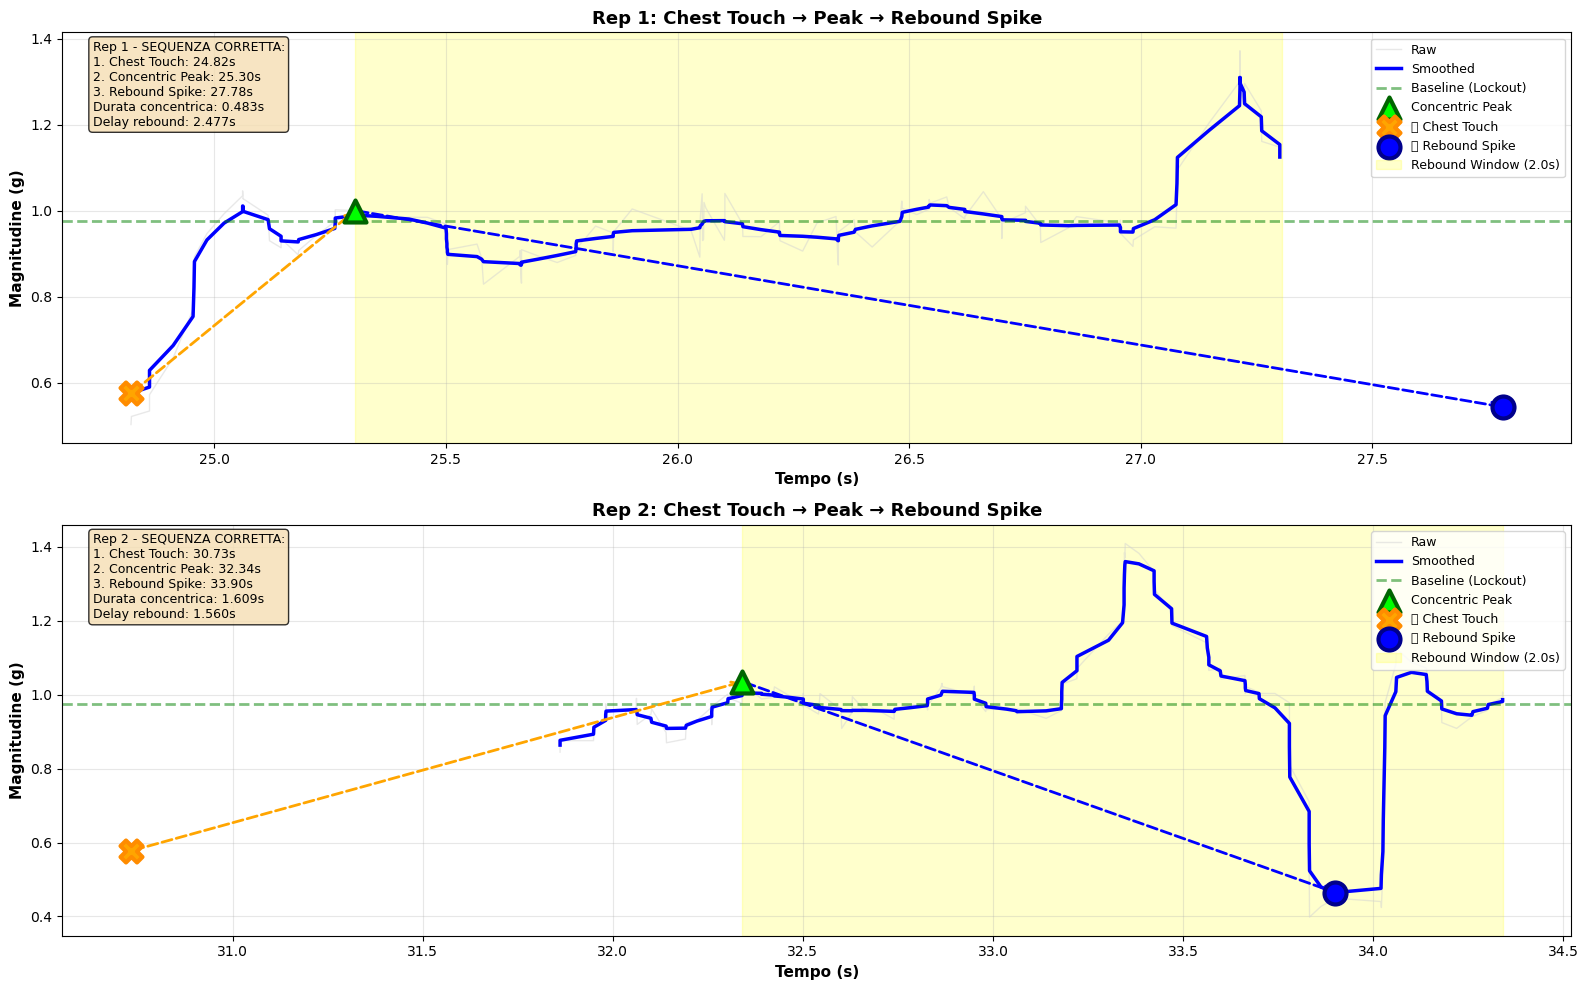

✅ Visualizzazione dettagliata completata!
💡 SEQUENZA CORRETTA:
  • 🟠 X ARANCIONI = CHEST TOUCHES (dip profondi)
  • ▲ TRIANGOLI VERDI = CONCENTRIC PEAKS (lockout)
  • 🔵 PALLINI BLU = REBOUND SPIKES (bottoms originali)
  • Sequenza: Chest Touch → Peak → Rebound Spike


In [ ]:
if len(validated_reps_df) > 0:
    # Crea plot dettagliato per prime 2-3 reps usando validated_reps_df
    num_reps_to_show = min(3, len(validated_reps_df))
    
    fig, axes = plt.subplots(num_reps_to_show, 1, figsize=(16, 5 * num_reps_to_show))
    if num_reps_to_show == 1:
        axes = [axes]
    
    for i in range(num_reps_to_show):
        ax = axes[i]
        
        # Trova indici per questa rep dal validated_reps_df
        peak_idx = validated_reps_df.loc[i, 'peak_idx']
        rebound_spike_idx = validated_reps_df.loc[i, 'rebound_spike_idx']
        chest_touch_idx = validated_reps_df.loc[i, 'chest_touch_idx']
        
        # Trova finestra temporale da mostrare (±1 secondo dal picco)
        peak_time = df.loc[peak_idx, 'Timestamp']
        window_start = peak_time - 0.5
        window_end = peak_time + 2.0
        window_mask = (df['Timestamp'] >= window_start) & (df['Timestamp'] <= window_end)
        
        # Plot magnitudine
        ax.plot(df.loc[window_mask, 'Timestamp'], 
                df.loc[window_mask, 'Magnitude (g)'], 
                'lightgray', alpha=0.5, linewidth=1, label='Raw')
        ax.plot(df.loc[window_mask, 'Timestamp'], 
                df.loc[window_mask, 'Mag_smooth'], 
                'blue', linewidth=2.5, label='Smoothed')
        
        # Baseline
        ax.axhline(y=baseline_mag_mean, color='green', linestyle='--', 
                   linewidth=2, alpha=0.5, label='Baseline (Lockout)')
        
        # Markers
        # 1. Concentric Peak
        ax.scatter(df.loc[peak_idx, 'Timestamp'], 
                   df.loc[peak_idx, 'Magnitude (g)'],
                   s=250, marker='^', color='lime', edgecolors='darkgreen', 
                   linewidths=3, zorder=10, label='Concentric Peak')
        
        # 2. Chest Touch (tocco petto - X arancione)
        ax.scatter(df.loc[chest_touch_idx, 'Timestamp'], 
                   df.loc[chest_touch_idx, 'Mag_smooth'],
                   s=250, marker='X', color='orange', edgecolors='darkorange', 
                   linewidths=3, zorder=10, label='🟠 Chest Touch')
        
        # 3. Rebound Spike (bottoms originali - pallino blu)
        ax.scatter(df.loc[rebound_spike_idx, 'Timestamp'], 
                   df.loc[rebound_spike_idx, 'Mag_smooth'],
                   s=250, marker='o', color='blue', edgecolors='darkblue', 
                   linewidths=3, zorder=10, label='🔵 Rebound Spike')
        
        # Zona rebound (area grigia)
        rebound_search_window = 2.0  # Finestra di ricerca rebound
        rebound_window_end = peak_time + rebound_search_window
        ax.axvspan(peak_time, rebound_window_end, 
                   color='yellow', alpha=0.2, zorder=1, label=f'Rebound Window ({rebound_search_window}s)')
        
        # Annotazioni con frecce
        # Freccia Peak → Rebound Spike
        ax.annotate('', xy=(df.loc[rebound_spike_idx, 'Timestamp'], df.loc[rebound_spike_idx, 'Mag_smooth']),
                    xytext=(df.loc[peak_idx, 'Timestamp'], df.loc[peak_idx, 'Magnitude (g)']),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=2, linestyle='--'))
        
        # Freccia Chest Touch → Peak
        ax.annotate('', xy=(df.loc[peak_idx, 'Timestamp'], df.loc[peak_idx, 'Magnitude (g)']),
                    xytext=(df.loc[chest_touch_idx, 'Timestamp'], df.loc[chest_touch_idx, 'Mag_smooth']),
                    arrowprops=dict(arrowstyle='->', color='orange', lw=2, linestyle='--'))
        
        # Testo informativo
        concentric_duration = df.loc[peak_idx, 'Timestamp'] - df.loc[chest_touch_idx, 'Timestamp']
        rebound_delay = df.loc[rebound_spike_idx, 'Timestamp'] - df.loc[peak_idx, 'Timestamp']
        
        info_text = (f"Rep {i+1} - SEQUENZA CORRETTA:\n"
                    f"1. Chest Touch: {df.loc[chest_touch_idx, 'Timestamp']:.2f}s\n"
                    f"2. Concentric Peak: {df.loc[peak_idx, 'Timestamp']:.2f}s\n"
                    f"3. Rebound Spike: {df.loc[rebound_spike_idx, 'Timestamp']:.2f}s\n"
                    f"Durata concentrica: {concentric_duration:.3f}s\n"
                    f"Delay rebound: {rebound_delay:.3f}s")
        
        ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=11)
        ax.set_xlabel('Tempo (s)', fontweight='bold', fontsize=11)
        ax.set_title(f'Rep {i+1}: Chest Touch → Peak → Rebound Spike', 
                     fontsize=13, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizzazione dettagliata completata!")
    print("💡 SEQUENZA CORRETTA:")
    print("  • 🟠 X ARANCIONI = CHEST TOUCHES (dip profondi)")
    print("  • ▲ TRIANGOLI VERDI = CONCENTRIC PEAKS (lockout)")
    print("  • 🔵 PALLINI BLU = REBOUND SPIKES (bottoms originali)")
    print("  • Sequenza: Chest Touch → Peak → Rebound Spike")
else:
    print("⚠️  Nessuna rep validata per visualizzare dettaglio")

## 10. Visualizzazione Completa con Fasi Annotate

C:\Users\UserDemo\AppData\Local\Temp\ipykernel_11724\4195761582.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\UserDemo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\UserDemo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\UserDemo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


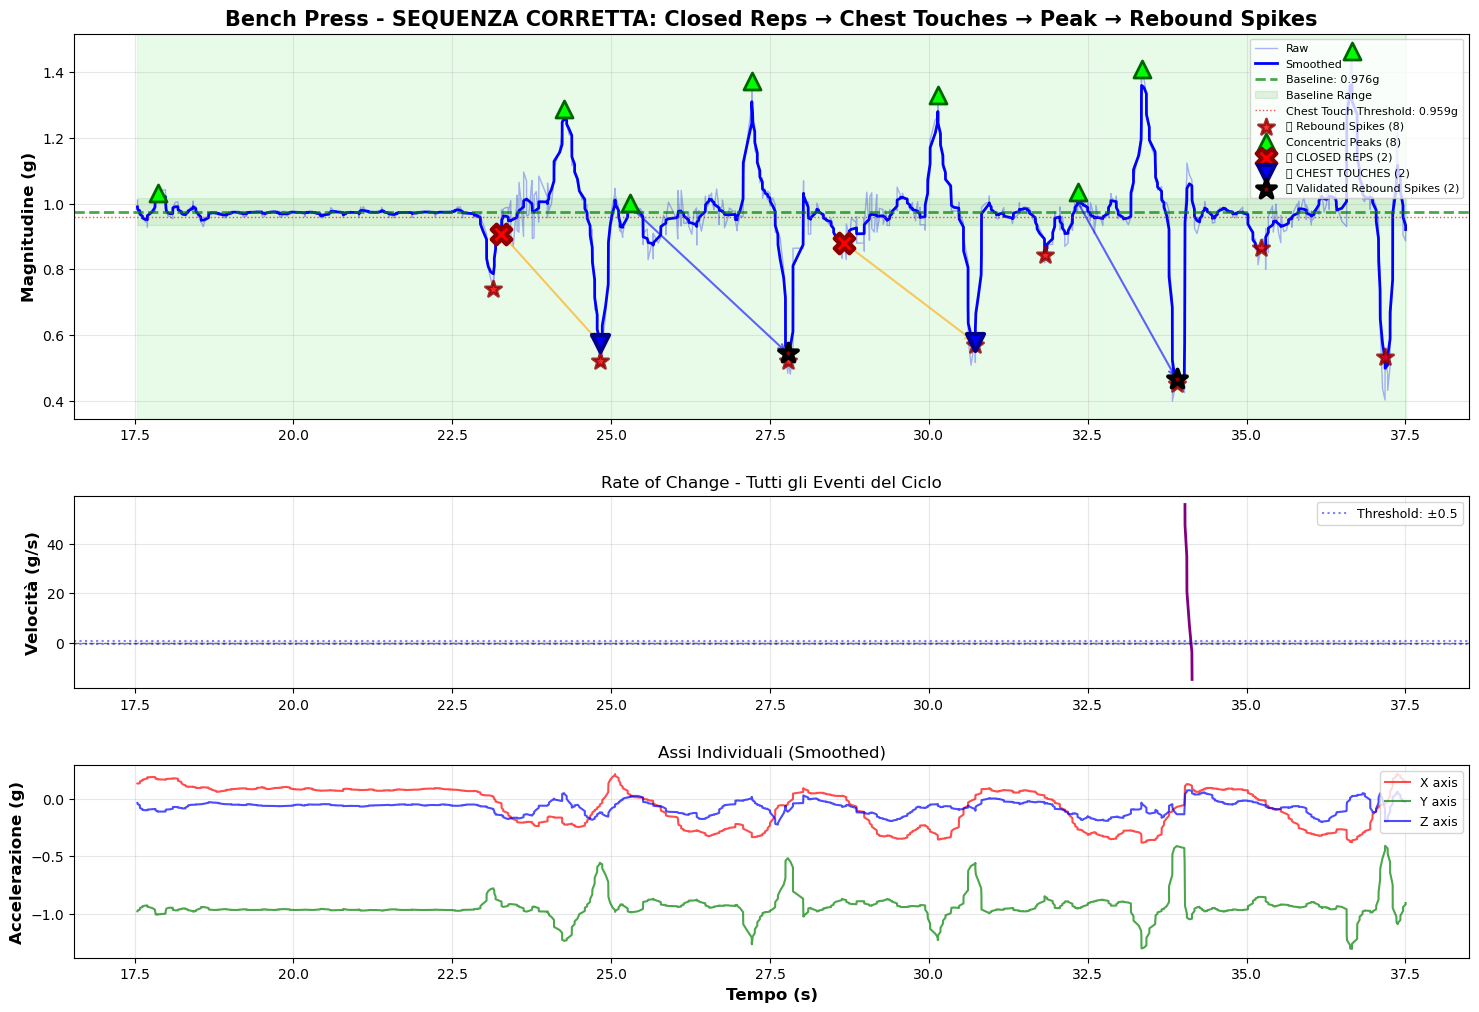


✅ Visualizzazione CORRETTA generata!

💡 LEGENDA CORRETTA:
  • 🔴 X ROSSE = CLOSED REPS (attraversamento baseline → inizio movimento)
  • ▲ Triangoli VERDI = CONCENTRIC PEAKS (spinta forte e veloce al lockout)
  • 🔵 Spike BLU = CHEST TOUCHES (tocco del petto)
  • ⭐ Asterischi ROSSI = REBOUND SPIKES (grandi spike opposte del rinculo)
  • Frecce ARANCIONI = Closed Rep → Chest Touch
  • Frecce BLU = Peak → Rebound Spike

📊 CONTEGGIO SEQUENZA CORRETTA:
  • Ripetizioni complete: 2
  • Picchi concentrici: 8
  • Closed reps: 2
  • Chest touches: 2
  • Rebound spikes: 2


In [ ]:
# Crea una visualizzazione completa con TUTTI i markers (inclusi baseline returns)
fig = plt.figure(figsize=(18, 12))

# Layout: 3 righe
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.3)

# Plot 1: Magnitudine con fasi e markers
ax1 = fig.add_subplot(gs[0])

# Plot magnitudine
ax1.plot(df['Timestamp'], df['Magnitude (g)'], 'b-', alpha=0.3, linewidth=1, label='Raw')
ax1.plot(df['Timestamp'], df['Mag_smooth'], 'b-', linewidth=2, label='Smoothed')

# Baseline range
ax1.axhline(y=baseline_mag_mean, color='green', linestyle='--', linewidth=2, 
            label=f'Baseline: {baseline_mag_mean:.3f}g', alpha=0.7)
ax1.fill_between(df['Timestamp'], baseline_mag_min, baseline_mag_max, 
                 color='green', alpha=0.1, label='Baseline Range')

# Soglia per chest touch
ax1.axhline(y=BASELINE_THRESHOLD, color='red', linestyle=':', linewidth=1, 
            label=f'Chest Touch Threshold: {BASELINE_THRESHOLD:.3f}g', alpha=0.7)

# Marca i REBOUND SPIKES (grandi spike opposte - asterischi rossi)
if len(bottoms_idx) > 0:
    ax1.scatter(df.loc[bottoms_idx, 'Timestamp'], 
                df.loc[bottoms_idx, 'Magnitude (g)'], 
                color='red', s=150, zorder=4, marker='*', alpha=0.8,
                label=f'⭐ Rebound Spikes ({len(bottoms_idx)})', 
                edgecolors='darkred', linewidths=2)

# Marca i picchi concentrici
if len(peaks_idx) > 0:
    ax1.scatter(df.loc[peaks_idx, 'Timestamp'], 
                df.loc[peaks_idx, 'Magnitude (g)'], 
                color='lime', s=150, zorder=6, marker='^',
                label=f'Concentric Peaks ({len(peaks_idx)})', 
                edgecolors='darkgreen', linewidths=2)

# Prepara i DataFrame dalla nuova struttura dati
if len(validated_reps_df) > 0:
    # CLOSED REPS = Attraversamenti baseline (X rosse)
    closed_rep_indices = validated_reps_df['closed_rep_idx'].values
    ax1.scatter(df.loc[closed_rep_indices, 'Timestamp'], 
                df.loc[closed_rep_indices, 'Mag_smooth'], 
                color='red', s=200, zorder=8, marker='X',
                label=f'🔴 CLOSED REPS ({len(validated_reps_df)})', 
                edgecolors='darkred', linewidths=3)

    # CHEST TOUCHES = Spike blu di tocco petto
    chest_touch_indices = validated_reps_df['chest_touch_idx'].values
    ax1.scatter(df.loc[chest_touch_indices, 'Timestamp'], 
                df.loc[chest_touch_indices, 'Mag_smooth'], 
                color='blue', s=150, zorder=7, marker='v',
                label=f'🔵 CHEST TOUCHES ({len(validated_reps_df)})', 
                edgecolors='darkblue', linewidths=3)

    # REBOUND SPIKES VALIDATI = Grandi spike opposte evidenziate
    rebound_spike_indices = validated_reps_df['rebound_spike_idx'].values
    ax1.scatter(df.loc[rebound_spike_indices, 'Timestamp'], 
                df.loc[rebound_spike_indices, 'Mag_smooth'], 
                color='darkred', s=200, zorder=9, marker='*',
                label=f'⭐ Validated Rebound Spikes ({len(validated_reps_df)})', 
                edgecolors='black', linewidths=3)

# Colora le fasi
phase_colors = {
    'BASELINE': 'lightgreen',
    'ECCENTRIC': 'lightcoral',
    'BOTTOM': 'yellow',
    'CONCENTRIC': 'lightblue'
}

for _, phase in phases_df.iterrows():
    start_time = df.loc[phase['start_idx'], 'Timestamp']
    end_time = df.loc[phase['end_idx'], 'Timestamp']
    ax1.axvspan(start_time, end_time, alpha=0.2, 
                color=phase_colors.get(phase['phase'], 'gray'))

# Aggiungi frecce per mostrare la sequenza corretta
if len(validated_reps_df) > 0:
    for i, row in validated_reps_df.iterrows():
        # Closed rep → Chest touch
        closed_time = row['closed_rep_time'] 
        closed_mag = row['closed_rep_mag']
        chest_time = row['chest_touch_time']
        chest_mag = row['chest_touch_mag']
        
        # Freccia da closed rep a chest touch (arancione)
        ax1.annotate('', xy=(chest_time, chest_mag),
                    xytext=(closed_time, closed_mag),
                    arrowprops=dict(arrowstyle='->', color='orange', lw=1.5, alpha=0.6))
        
        # Peak → Rebound spike  
        peak_time = row['peak_time']
        peak_mag = row['peak_mag']
        rebound_time = row['rebound_spike_time']
        rebound_mag = row['rebound_spike_mag']
        
        # Freccia da peak a rebound spike (blu)
        ax1.annotate('', xy=(rebound_time, rebound_mag),
                    xytext=(peak_time, peak_mag),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=1.5, alpha=0.6))

ax1.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
ax1.set_title('Bench Press - SEQUENZA CORRETTA: Closed Reps → Chest Touches → Peak → Rebound Spikes', fontsize=15, fontweight='bold')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Velocità della magnitudine
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(df['Timestamp'], df['Mag_velocity_smooth'], 'purple', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
ax2.axhline(y=VELOCITY_THRESHOLD, color='blue', linestyle=':', alpha=0.5, 
            label=f'Threshold: ±{VELOCITY_THRESHOLD}')
ax2.axhline(y=-VELOCITY_THRESHOLD, color='blue', linestyle=':', alpha=0.5)
ax2.fill_between(df['Timestamp'], -VELOCITY_THRESHOLD, VELOCITY_THRESHOLD, 
                 color='gray', alpha=0.1)

# Marca tutti i punti chiave sulla velocità
if len(validated_reps_df) > 0:
    # Closed reps
    closed_times = validated_reps_df['closed_rep_time'].values
    ax2.scatter(closed_times, 
               [df.loc[df['Timestamp'] == t, 'Mag_velocity_smooth'].iloc[0] for t in closed_times], 
               color='red', s=100, zorder=5, marker='v')

    # Chest touches
    chest_times = validated_reps_df['chest_touch_time'].values
    ax2.scatter(chest_times, 
               [df.loc[df['Timestamp'] == t, 'Mag_velocity_smooth'].iloc[0] for t in chest_times], 
               color='orange', s=100, zorder=5, marker='X')

    # Rebound spikes
    rebound_times = validated_reps_df['rebound_spike_time'].values
    ax2.scatter(rebound_times, 
               [df.loc[df['Timestamp'] == t, 'Mag_velocity_smooth'].iloc[0] for t in rebound_times], 
               color='blue', s=100, zorder=5, marker='o')

ax2.set_ylabel('Velocità (g/s)', fontweight='bold', fontsize=12)
ax2.set_title('Rate of Change - Tutti gli Eventi del Ciclo', fontsize=12)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Assi individuali
ax3 = fig.add_subplot(gs[2], sharex=ax1)
ax3.plot(df['Timestamp'], df['X_smooth'], 'r-', alpha=0.7, linewidth=1.5, label='X axis')
ax3.plot(df['Timestamp'], df['Y_smooth'], 'g-', alpha=0.7, linewidth=1.5, label='Y axis')
ax3.plot(df['Timestamp'], df['Z_smooth'], 'b-', alpha=0.7, linewidth=1.5, label='Z axis')
ax3.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
ax3.set_ylabel('Accelerazione (g)', fontweight='bold', fontsize=12)
ax3.set_title('Assi Individuali (Smoothed)', fontsize=12)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualizzazione CORRETTA generata!")
print("\n💡 LEGENDA CORRETTA:")
print("  • 🔴 X ROSSE = CLOSED REPS (attraversamento baseline → inizio movimento)")
print("  • ▲ Triangoli VERDI = CONCENTRIC PEAKS (spinta forte e veloce al lockout)")
print("  • 🔵 Spike BLU = CHEST TOUCHES (tocco del petto)")
print("  • ⭐ Asterischi ROSSI = REBOUND SPIKES (grandi spike opposte del rinculo)")
print("  • Frecce ARANCIONI = Closed Rep → Chest Touch")
print("  • Frecce BLU = Peak → Rebound Spike")
print(f"\n📊 CONTEGGIO SEQUENZA CORRETTA:")
if len(validated_reps_df) > 0:
    print(f"  • Ripetizioni complete: {len(validated_reps_df)}")
    print(f"  • Picchi concentrici: {len(peaks_idx)}")
    print(f"  • Closed reps: {len(validated_reps_df)}")
    print(f"  • Chest touches: {len(validated_reps_df)}")
    print(f"  • Rebound spikes: {len(validated_reps_df)}")
else:
    print("  • Nessuna ripetizione completa rilevata")

## 11. Summary Report

Riepilogo completo dell'analisi del bench press.

## VBT Analysis - Velocity Based Training

Calcolo delle metriche VBT per ogni ripetizione validata:
- **Mean Velocity (MV)** - Velocità media della fase concentrica in m/s
- **Peak Velocity (PV)** - Velocità massima raggiunta in m/s
- **Mean Propulsive Velocity (MPV)** - Velocità media nella fase propulsiva (solo quando accelerazione > 0)
- **Mean Power** - Potenza media in Watt
- **Peak Power** - Potenza massima in Watt
- **ROM** - Range of Motion (spostamento verticale)
- **Velocity Loss** - Perdita di velocità tra prima e ultima ripetizione (indicatore di fatica)

In [ ]:
"""
CALCOLO METRICHE VBT (Velocity Based Training)
Per ogni ripetizione validata, calcola velocità e potenza della fase concentrica
"""

# Configurazione massa (da modificare con il peso reale del bilanciere + dischi)
MASS_KG = 60.0  # kg - MODIFICA QUESTO VALORE con la massa reale!

print("="*90)
print(" "*30 + "VBT ANALYSIS")
print("="*90)
print(f"\n⚙️  Configuration: Mass = {MASS_KG} kg")
print(f"   Gravity compensation: Subtracting 1.0g (9.81 m/s²) from all readings")
print("="*90)

# Lista per memorizzare le ripetizioni con metriche VBT
vbt_reps = []

if len(validated_reps_df) > 0:
    for idx, rep_row in validated_reps_df.iterrows():
        rep_num = idx + 1  # Usa l'indice come numero ripetizione
        chest_idx = int(rep_row['chest_touch_idx'])  # Converti in intero!
        peak_idx = int(rep_row['peak_idx'])  # Converti in intero!
        
        # Estrai fase concentrica (chest touch → peak)
        if peak_idx <= chest_idx:
            print(f"⚠️  Rep {rep_num}: Invalid - peak before chest touch")
            continue
            
        # Dati della fase concentrica
        concentric_data = df.iloc[chest_idx:peak_idx+1].copy()
        
        if len(concentric_data) < 5:  # Minimo 5 samples
            print(f"⚠️  Rep {rep_num}: Too few samples in concentric phase ({len(concentric_data)})")
            continue
        
        # Estrai vettori
        mag_concentric = concentric_data['Mag_smooth'].values
        time_concentric = concentric_data['Timestamp'].values
        
        # GRAVITY COMPENSATION - Sottrai 1.0g (non baseline variabile!)
        # Questo è lo standard in tutti i dispositivi VBT professionali
        mag_accel_net = (mag_concentric - 1.0) * 9.81  # Converti in m/s²
        
        # Integrazione numerica per calcolare velocità: v(t) = v(t-1) + a(t) * dt
        velocity = np.zeros(len(mag_accel_net))
        displacement = np.zeros(len(mag_accel_net))
        
        for k in range(1, len(mag_accel_net)):
            dt = time_concentric[k] - time_concentric[k-1]
            velocity[k] = velocity[k-1] + mag_accel_net[k] * dt
            displacement[k] = displacement[k-1] + velocity[k] * dt
        
        # Calcola propulsive mask (solo dove accelerazione è positiva)
        propulsive_mask = mag_accel_net > 0
        
        # === METRICHE VBT ===
        
        # 1. Mean Velocity (MV) - velocità media (solo valori positivi)
        positive_velocity = velocity[velocity > 0]
        if len(positive_velocity) > 0:
            mean_velocity = np.mean(positive_velocity)
            peak_velocity = np.max(velocity)
        else:
            mean_velocity = 0.0
            peak_velocity = 0.0
        
        # 2. Mean Propulsive Velocity (MPV) - velocità media nella fase propulsiva
        if np.any(propulsive_mask):
            mean_propulsive_velocity = np.mean(velocity[propulsive_mask])
        else:
            mean_propulsive_velocity = 0.0
        
        # 3. Time to Peak Velocity
        peak_vel_idx = np.argmax(velocity)
        time_to_peak_velocity = time_concentric[peak_vel_idx] - time_concentric[0]
        
        # 4. ROM (Range of Motion) - spostamento verticale totale
        rom = displacement[-1]  # Spostamento finale
        
        # 5. Potenza: P = F * v = m * a * v
        force = MASS_KG * mag_accel_net  # Newton
        power = force * velocity  # Watt
        
        mean_power = np.mean(power[power > 0]) if np.any(power > 0) else 0.0
        peak_power = np.max(power)
        
        # 6. Mean Propulsive Power (MPP) - potenza nella fase propulsiva
        if np.any(propulsive_mask):
            mean_propulsive_power = np.mean(power[propulsive_mask])
        else:
            mean_propulsive_power = 0.0
        
        # 7. Durate fasi
        concentric_duration = time_concentric[-1] - time_concentric[0]
        
        # Salva risultati
        vbt_rep = {
            'rep_num': rep_num,
            'chest_idx': chest_idx,
            'peak_idx': peak_idx,
            'chest_time': time_concentric[0],
            'peak_time': time_concentric[-1],
            'concentric_duration': concentric_duration,
            'mean_velocity': mean_velocity,
            'peak_velocity': peak_velocity,
            'mean_propulsive_velocity': mean_propulsive_velocity,
            'time_to_peak_velocity': time_to_peak_velocity,
            'rom': rom,
            'mean_power': mean_power,
            'peak_power': peak_power,
            'mean_propulsive_power': mean_propulsive_power,
            'mag_start': mag_concentric[0],
            'mag_peak': mag_concentric[-1]
        }
        vbt_reps.append(vbt_rep)
        
        # Print dettagliato per ogni rep
        print(f"\n🏋️  REP #{rep_num}")
        print(f"   ⏱️  Time: {vbt_rep['chest_time']:.2f}s → {vbt_rep['peak_time']:.2f}s (Δ={concentric_duration:.3f}s)")
        print(f"   📈 Magnitude: {vbt_rep['mag_start']:.3f}g → {vbt_rep['mag_peak']:.3f}g")
        print(f"   🚀 VELOCITÀ:")
        print(f"      • Mean Velocity (MV):      {mean_velocity:.3f} m/s")
        print(f"      • Peak Velocity (PV):      {peak_velocity:.3f} m/s")
        print(f"      • Mean Propulsive (MPV):   {mean_propulsive_velocity:.3f} m/s")
        print(f"      • Time to Peak:            {time_to_peak_velocity:.3f}s")
        print(f"   💪 POTENZA:")
        print(f"      • Mean Power:              {mean_power:.1f} W")
        print(f"      • Peak Power:              {peak_power:.1f} W")
        print(f"      • Mean Propulsive Power:   {mean_propulsive_power:.1f} W")
        print(f"   📏 ROM (displacement):        {rom:.3f} m ({rom*100:.1f} cm)")
    
    print("\n" + "="*90)
    
    # Crea DataFrame con risultati VBT
    vbt_df = pd.DataFrame(vbt_reps)
    
    if len(vbt_df) > 0:
        print(f"\n📊 VBT SUMMARY STATISTICS ({len(vbt_df)} reps)")
        print("="*90)
        
        # Statistiche aggregate
        print(f"\n🚀 VELOCITY METRICS (m/s)")
        print(f"   Mean Velocity (MV):           {vbt_df['mean_velocity'].mean():.3f} ± {vbt_df['mean_velocity'].std():.3f} m/s")
        print(f"   Peak Velocity (PV):           {vbt_df['peak_velocity'].mean():.3f} ± {vbt_df['peak_velocity'].std():.3f} m/s")
        print(f"   Mean Propulsive Velocity:     {vbt_df['mean_propulsive_velocity'].mean():.3f} ± {vbt_df['mean_propulsive_velocity'].std():.3f} m/s")
        print(f"   Range: {vbt_df['mean_velocity'].min():.3f} - {vbt_df['mean_velocity'].max():.3f} m/s")
        
        print(f"\n💪 POWER METRICS (Watts)")
        print(f"   Mean Power:                   {vbt_df['mean_power'].mean():.1f} ± {vbt_df['mean_power'].std():.1f} W")
        print(f"   Peak Power:                   {vbt_df['peak_power'].mean():.1f} ± {vbt_df['peak_power'].std():.1f} W")
        print(f"   Mean Propulsive Power:        {vbt_df['mean_propulsive_power'].mean():.1f} ± {vbt_df['mean_propulsive_power'].std():.1f} W")
        
        print(f"\n📏 ROM (Range of Motion)")
        print(f"   Average:                      {vbt_df['rom'].mean():.3f} m ({vbt_df['rom'].mean()*100:.1f} cm)")
        print(f"   Std Dev:                      {vbt_df['rom'].std():.3f} m ({vbt_df['rom'].std()*100:.1f} cm)")
        print(f"   Range:                        {vbt_df['rom'].min():.3f} - {vbt_df['rom'].max():.3f} m")
        
        print(f"\n⏱️  TIMING")
        print(f"   Concentric Duration:          {vbt_df['concentric_duration'].mean():.3f} ± {vbt_df['concentric_duration'].std():.3f} s")
        print(f"   Time to Peak Velocity:        {vbt_df['time_to_peak_velocity'].mean():.3f} ± {vbt_df['time_to_peak_velocity'].std():.3f} s")
        
        # VELOCITY LOSS - indicatore chiave di fatica!
        if len(vbt_df) > 1:
            first_mv = vbt_df.iloc[0]['mean_velocity']
            last_mv = vbt_df.iloc[-1]['mean_velocity']
            velocity_loss = ((first_mv - last_mv) / first_mv) * 100
            
            print(f"\n📉 VELOCITY LOSS (VL%)")
            print(f"   Rep 1 MV:                     {first_mv:.3f} m/s")
            print(f"   Rep {len(vbt_df)} MV:                     {last_mv:.3f} m/s")
            print(f"   Velocity Loss:                {velocity_loss:.1f}%")
            
            if velocity_loss > 20:
                print(f"   Status: ⚠️  HIGH FATIGUE (VL > 20%)")
                print(f"           Stop set or reduce load!")
            elif velocity_loss > 10:
                print(f"   Status: ⚡ MODERATE FATIGUE (VL 10-20%)")
                print(f"           Approaching failure zone")
            else:
                print(f"   Status: ✅ MINIMAL FATIGUE (VL < 10%)")
                print(f"           Good velocity maintenance")
        
        print("\n" + "="*90)
        print("✅ VBT Analysis Complete!")
        print("="*90)
        
        # Mostra DataFrame
        print("\n📋 Complete VBT Data:")
        display(vbt_df[['rep_num', 'mean_velocity', 'peak_velocity', 'mean_propulsive_velocity', 
                        'mean_power', 'peak_power', 'rom', 'concentric_duration']])
    
else:
    print("\n⚠️  No validated reps available for VBT analysis")
    vbt_df = pd.DataFrame()

                              VBT ANALYSIS

⚙️  Configuration: Mass = 60.0 kg
   Gravity compensation: Subtracting 1.0g (9.81 m/s²) from all readings


TypeError: cannot do positional indexing on RangeIndex with these indexers [372.0] of type float64

## VBT Visualization - Velocity and Power Trends

In [ ]:
if len(vbt_df) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    rep_numbers = vbt_df['rep_num'].values
    
    # SUBPLOT 1: Velocity Metrics
    ax1 = axes[0]
    ax1.plot(rep_numbers, vbt_df['mean_velocity'], 'o-', linewidth=2.5, markersize=10, 
             label='Mean Velocity (MV)', color='blue')
    ax1.plot(rep_numbers, vbt_df['peak_velocity'], 's-', linewidth=2.5, markersize=10, 
             label='Peak Velocity (PV)', color='red')
    ax1.plot(rep_numbers, vbt_df['mean_propulsive_velocity'], '^-', linewidth=2.5, markersize=10, 
             label='Mean Propulsive Velocity (MPV)', color='green')
    
    # Aggiungi linea di tendenza per MV
    if len(rep_numbers) > 1:
        z = np.polyfit(rep_numbers, vbt_df['mean_velocity'], 1)
        p = np.poly1d(z)
        ax1.plot(rep_numbers, p(rep_numbers), "--", alpha=0.5, color='blue', 
                label=f'Trend MV (slope: {z[0]:.4f} m/s per rep)')
    
    ax1.set_xlabel('Ripetizione', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Velocità (m/s)', fontweight='bold', fontsize=12)
    ax1.set_title('VBT - Analisi Velocità per Ripetizione', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10, loc='best')
    ax1.set_xticks(rep_numbers)
    
    # Evidenzia zona di fatiga se VL > 20%
    if len(vbt_df) > 1:
        first_mv = vbt_df.iloc[0]['mean_velocity']
        for i, row in vbt_df.iterrows():
            vl = ((first_mv - row['mean_velocity']) / first_mv) * 100
            if vl > 20:
                ax1.axvspan(row['rep_num']-0.4, row['rep_num']+0.4, color='red', alpha=0.1)
            elif vl > 10:
                ax1.axvspan(row['rep_num']-0.4, row['rep_num']+0.4, color='orange', alpha=0.1)
    
    # SUBPLOT 2: Power Metrics
    ax2 = axes[1]
    ax2.plot(rep_numbers, vbt_df['mean_power'], 'o-', linewidth=2.5, markersize=10, 
             label='Mean Power', color='purple')
    ax2.plot(rep_numbers, vbt_df['peak_power'], 's-', linewidth=2.5, markersize=10, 
             label='Peak Power', color='orange')
    ax2.plot(rep_numbers, vbt_df['mean_propulsive_power'], '^-', linewidth=2.5, markersize=10, 
             label='Mean Propulsive Power', color='brown')
    
    ax2.set_xlabel('Ripetizione', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Potenza (W)', fontweight='bold', fontsize=12)
    ax2.set_title('VBT - Analisi Potenza per Ripetizione', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10, loc='best')
    ax2.set_xticks(rep_numbers)
    
    # SUBPLOT 3: ROM and Timing
    ax3 = axes[2]
    ax3_rom = ax3
    ax3_time = ax3.twinx()
    
    line1 = ax3_rom.plot(rep_numbers, vbt_df['rom']*100, 'o-', linewidth=2.5, markersize=10, 
                         label='ROM (cm)', color='teal')
    line2 = ax3_time.plot(rep_numbers, vbt_df['concentric_duration'], 's-', linewidth=2.5, 
                          markersize=10, label='Concentric Duration (s)', color='coral')
    
    ax3_rom.set_xlabel('Ripetizione', fontweight='bold', fontsize=12)
    ax3_rom.set_ylabel('ROM (cm)', fontweight='bold', fontsize=12, color='teal')
    ax3_time.set_ylabel('Durata Concentrica (s)', fontweight='bold', fontsize=12, color='coral')
    ax3_rom.set_title('VBT - ROM e Timing', fontsize=14, fontweight='bold')
    ax3_rom.grid(True, alpha=0.3)
    ax3_rom.set_xticks(rep_numbers)
    ax3_rom.tick_params(axis='y', labelcolor='teal')
    ax3_time.tick_params(axis='y', labelcolor='coral')
    
    # Combina legende
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3_rom.legend(lines, labels, fontsize=10, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ VBT Visualization complete!")
    
    # Aggiungi interpretazione
    print("\n📊 INTERPRETATION GUIDE:")
    print("="*70)
    print("🚀 VELOCITY:")
    print("   • Declining MV = increasing fatigue")
    print("   • VL < 10% = minimal fatigue, can continue")
    print("   • VL 10-20% = moderate fatigue, approaching limit")
    print("   • VL > 20% = high fatigue, stop or reduce load")
    print("\n💪 POWER:")
    print("   • Should correlate with velocity")
    print("   • Declining power = neuromuscular fatigue")
    print("\n📏 ROM:")
    print("   • Should remain consistent (±5%)")
    print("   • Decreasing ROM = form breakdown or fatigue")
    print("   • Increasing ROM = compensatory pattern")
    print("\n⏱️  TIMING:")
    print("   • Concentric duration increasing = losing explosiveness")
    print("   • Should stay within 10% of first rep")
    print("="*70)
    
else:
    print("⚠️  No VBT data to visualize")

In [ ]:
print("="*70)
print(" "*20 + "BENCH PRESS ANALYSIS REPORT")
print("="*70)

print("\n📊 DATASET INFO")
print(f"  • File: {filename}")
print(f"  • Duration: {df['Timestamp'].max() - df['Timestamp'].min():.2f} seconds")
print(f"  • Samples: {len(df)}")
print(f"  • Sampling Rate: ~{len(df)/(df['Timestamp'].max() - df['Timestamp'].min()):.1f} Hz")

print("\n🔒 BASELINE (LOCKOUT)")
print(f"  • Mean Magnitude: {baseline_mag_mean:.4f}g")
print(f"  • Std Deviation: {baseline_mag_std:.4f}g")
print(f"  • Range: {baseline_mag_min:.4f}g - {baseline_mag_max:.4f}g")

print(f"\n🏋️ REPS DETECTED: {len(bottoms_idx)}")
if len(bottoms_idx) > 0:
    print(f"  • Average Bottom Magnitude: {bottoms_df['Magnitude (g)'].mean():.4f}g")
    print(f"  • Average Depth: {bottoms_df['Depth from Baseline'].mean():.4f}g")
    print(f"  • Min Bottom: {bottoms_df['Magnitude (g)'].min():.4f}g")
    print(f"  • Max Bottom: {bottoms_df['Magnitude (g)'].max():.4f}g")

print(f"\n💪 CONCENTRIC POWER")
if len(peaks_idx) > 0:
    print(f"  • Number of Peaks: {len(peaks_idx)}")
    print(f"  • Average Peak: {peaks_df['Magnitude (g)'].mean():.4f}g")
    print(f"  • Max Peak: {peaks_df['Magnitude (g)'].max():.4f}g")
    print(f"  • Average Power above Baseline: {peaks_df['Power above Baseline'].mean():.4f}g")

print("\n⏱️  TIMING")
if len(rep_durations) > 0:
    print(f"  • Average Rep Duration: {rep_durations.mean():.2f}s")
    print(f"  • Rep Duration Range: {rep_durations.min():.2f}s - {rep_durations.max():.2f}s")
    print(f"  • Tempo Consistency (Std): {rep_durations.std():.2f}s")

print("\n🎯 PHASE BREAKDOWN")
for phase_name in ['BASELINE', 'ECCENTRIC', 'BOTTOM', 'CONCENTRIC']:
    phase_data = phases_df[phases_df['phase'] == phase_name]
    if len(phase_data) > 0:
        print(f"  • {phase_name:12s}: {len(phase_data):2d} occurrences, "
              f"avg {phase_data['duration'].mean():.2f}s ± {phase_data['duration'].std():.2f}s")

print("\n📈 MAGNITUDE STATISTICS")
print(f"  • Overall Range: {df['Magnitude (g)'].min():.4f}g - {df['Magnitude (g)'].max():.4f}g")
print(f"  • Mean: {df['Magnitude (g)'].mean():.4f}g")
print(f"  • Std: {df['Magnitude (g)'].std():.4f}g")
print(f"  • Total Excursion: {df['Magnitude (g)'].max() - df['Magnitude (g)'].min():.4f}g")

print("\n🔍 COMPARISON TO OTHER LIFTS")
print("  • Pattern: Eccentric → Bottom → Concentric (similar to Squat)")
print("  • Impact Events: NO (unlike Deadlift)")
print("  • ROM: Shorter than Squat")
print("  • Baseline Stability: High (lockout position)")
print(f"  • Depth Drop: {bottoms_df['Depth from Baseline'].mean():.4f}g "
      f"({(bottoms_df['Depth from Baseline'].mean()/baseline_mag_mean)*100:.1f}% of baseline)")

print("\n" + "="*70)
print("✅ Analysis Complete!")
print("="*70)

## 12. Recommended Thresholds for Production

Questi valori possono essere utilizzati per configurare un sistema di rilevamento automatico.

In [ ]:
print("="*70)
print("RECOMMENDED CONFIGURATION FOR BENCH PRESS DETECTION")
print("="*70)

print("\n# Bench Press Configuration")
print("BENCH_PRESS_CONFIG = {")
print(f"    # Baseline (Lockout)")
print(f"    'baseline_mag_mean': {baseline_mag_mean:.4f},")
print(f"    'baseline_mag_std': {baseline_mag_std:.4f},")
print(f"    'baseline_mag_min': {baseline_mag_min:.4f},")
print(f"    'baseline_mag_max': {baseline_mag_max:.4f},")
print(f"    ")
print(f"    # Thresholds")
print(f"    'bottom_threshold': {bottoms_df['Magnitude (g)'].max():.4f},  # Max magnitude at bottom")
print(f"    'eccentric_velocity_threshold': -{VELOCITY_THRESHOLD},  # Negative for descent")
print(f"    'concentric_velocity_threshold': {VELOCITY_THRESHOLD},  # Positive for press")
print(f"    ")
print(f"    # Peak Detection")
print(f"    'prominence': {prominence},")
print(f"    'min_distance': {min_distance},  # samples (~{min_distance/50:.1f}s at 50Hz)")
print(f"    ")
print(f"    # Timing")
print(f"    'min_rep_duration': {rep_durations.min():.2f},  # seconds")
print(f"    'max_rep_duration': {rep_durations.max():.2f},  # seconds")
print(f"    'expected_rep_duration': {rep_durations.mean():.2f},  # seconds")
print(f"    ")
print(f"    # Smoothing")
print(f"    'gaussian_sigma': {sigma},")
print("}")

print("\n" + "="*70)
print("\n💡 USAGE NOTES:")
print("  • Use baseline_mag_min/max to detect lockout position")
print("  • Use bottom_threshold to identify chest touch")
print("  • Use velocity thresholds to detect phase transitions")
print("  • Prominence and min_distance for peak detection (scipy.signal.find_peaks)")
print("  • Rep duration for validation and outlier detection")

## 13. Confronto Rep-by-Rep

Analisi dettagliata di ogni singola ripetizione.

In [ ]:
if len(bottoms_idx) > 1:
    print("="*80)
    print("REP-BY-REP ANALYSIS")
    print("="*80)
    
    for i in range(len(bottoms_idx) - 1):
        rep_num = i + 1
        start_idx = bottoms_idx[i]
        end_idx = bottoms_idx[i + 1]
        
        # Estrai dati per questo rep
        rep_data = df.iloc[start_idx:end_idx]
        
        # Calcola metriche
        rep_duration = df.loc[end_idx, 'Timestamp'] - df.loc[start_idx, 'Timestamp']
        bottom_mag = df.loc[start_idx, 'Magnitude (g)']
        max_mag = rep_data['Magnitude (g)'].max()
        depth = baseline_mag_mean - bottom_mag
        power = max_mag - baseline_mag_mean
        
        # Trova il tempo del picco
        peak_in_rep = rep_data['Magnitude (g)'].idxmax()
        time_to_peak = df.loc[peak_in_rep, 'Timestamp'] - df.loc[start_idx, 'Timestamp']
        
        print(f"\n🏋️  REP {rep_num}")
        print(f"  Time: {df.loc[start_idx, 'Timestamp']:.2f}s - {df.loc[end_idx, 'Timestamp']:.2f}s")
        print(f"  Duration: {rep_duration:.2f}s")
        print(f"  Bottom Magnitude: {bottom_mag:.4f}g")
        print(f"  Depth: {depth:.4f}g ({(depth/baseline_mag_mean)*100:.1f}% of baseline)")
        print(f"  Peak Magnitude: {max_mag:.4f}g")
        print(f"  Power: {power:.4f}g above baseline")
        print(f"  Time to Peak: {time_to_peak:.2f}s ({(time_to_peak/rep_duration)*100:.1f}% of rep)")
    
    print("\n" + "="*80)

## 14. Key Insights and Patterns

Osservazioni chiave emerse dall'analisi.

In [ ]:
print("="*80)
print("KEY INSIGHTS FROM BENCH PRESS DATA")
print("="*80)

print("\n1️⃣  BASELINE CHARACTERISTICS")
print(f"   • Very stable lockout position: {baseline_mag_std:.4f}g std deviation")
print(f"   • Mean magnitude at lockout: ~{baseline_mag_mean:.3f}g")
print("   • This provides excellent reference for detecting rep start/end")

print("\n2️⃣  ECCENTRIC PHASE (Bar Descent)")
avg_depth = bottoms_df['Depth from Baseline'].mean()
print(f"   • Average magnitude drop: {avg_depth:.4f}g")
print(f"   • Represents {(avg_depth/baseline_mag_mean)*100:.1f}% decrease from baseline")
print("   • Pattern is consistent and predictable")

print("\n3️⃣  BOTTOM PHASE (Chest Touch)")
print(f"   • Minimum magnitudes range: {bottoms_df['Magnitude (g)'].min():.4f}g - {bottoms_df['Magnitude (g)'].max():.4f}g")
print(f"   • Average: {bottoms_df['Magnitude (g)'].mean():.4f}g")
print("   • Clear minima make rep counting reliable")
print("   • Some variation in depth between reps (normal)")

print("\n4️⃣  CONCENTRIC PHASE (Press)")
avg_power = peaks_df['Power above Baseline'].mean()
max_power = peaks_df['Power above Baseline'].max()
print(f"   • Average power: {avg_power:.4f}g above baseline")
print(f"   • Max power: {max_power:.4f}g above baseline")
print(f"   • Peak magnitude: up to {peaks_df['Magnitude (g)'].max():.4f}g")
print("   • Shows explosive power generation")

print("\n5️⃣  TEMPO AND TIMING")
if len(rep_durations) > 0:
    tempo_cv = (rep_durations.std() / rep_durations.mean()) * 100
    print(f"   • Average rep duration: {rep_durations.mean():.2f}s")
    print(f"   • Coefficient of variation: {tempo_cv:.1f}%")
    if tempo_cv < 20:
        print("   • Tempo is CONSISTENT - good control")
    elif tempo_cv < 40:
        print("   • Tempo is MODERATE - acceptable variation")
    else:
        print("   • Tempo is VARIABLE - consider more consistent pacing")

print("\n6️⃣  COMPARISON TO SQUAT")
print("   SIMILARITIES:")
print("   • IDENTICAL phase pattern: Start HIGH → Eccentric → Bottom → Concentric → Return HIGH")
print("   • Both start from top position (squat: standing, bench: lockout)")
print("   • Clear magnitude drop during descent")
print("   • Return to stable baseline after rep")
print("   ")
print("   DIFFERENCES:")
print("   • Shorter ROM (range of motion)")
print("   • Horizontal vs vertical movement plane")
print("   • NO ground impact events")
print("   • Potentially faster tempo")
print("   ")
print("   ⚠️  IMPORTANT NOTE ON REBOUND:")
print("   • After concentric peak, you may see a second 'dip' in magnitude")
print("   • This is NOT the bar moving down - it's accelerometer oscillation!")
print("   • The sensor 'bounces back' after the rapid deceleration at lockout")
print("   • This rebound is a sensor artifact, not actual bar movement")

print("\n7️⃣  DETECTION RELIABILITY")
print(f"   • {len(bottoms_idx)} reps detected")
print(f"   • {len(peaks_idx)} concentric peaks detected")
print("   • High signal-to-noise ratio")
print("   • Minimal false positives expected")
print("   • Suitable for real-time feedback systems")

print("\n" + "="*80)
print("✅ Analysis demonstrates bench press is highly suitable for")
print("   accelerometer-based tracking and form analysis")
print("="*80)